In [ ]:
!pip install category_encoders

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# data prep
from sklearn.model_selection import train_test_split,cross_val_score,StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, RobustScaler, OneHotEncoder, StandardScaler, LabelEncoder
from category_encoders import BinaryEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# model
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# evaluation
from sklearn.metrics import classification_report, confusion_matrix, f1_score, recall_score, precision_score

# hyperparametertuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# feature selection
from sklearn.feature_selection import chi2

## Business Problem Understanding

**Context**


Sebuah bank ingin meningkatkan efektivitas kampanye pemasaran (marketing campaign) mereka untuk produk deposito berjangka (term deposit). Selama ini, bank menghubungi banyak sekali nasabah, baik nasabah lama maupun baru, untuk menawarkan produk ini. Namun, pendekatan ini memakan biaya operasional yang besar (misalnya, waktu agen call center, biaya SMS/email blast) dan memiliki tingkat konversi yang belum optimal, karena banyak nasabah yang dihubungi ternyata tidak tertarik.

Data nasabah yang relevan, seperti data demografi (usia, pekerjaan), status finansial (saldo), dan riwayat interaksi dengan kampanye sebelumnya, telah tersedia.

Target :

yes: Nasabah berlangganan deposito berjangka.

no: Nasabah tidak berlangganan deposito berjangka.

**Problem Statement :**

Biaya untuk menjalankan kampanye pemasaran menjadi tidak efisien ketika bank menargetkan semua nasabah tanpa melakukan penyaringan terlebih dahulu. Banyaknya sumber daya yang terbuang untuk menghubungi nasabah yang tidak potensial mengurangi profitabilitas kampanye. Bank ingin proses pemasaran ini menjadi lebih cerdas dan hemat biaya.

**Goals :**

Berdasarkan permasalahan tersebut, tujuan utama proyek ini adalah:

1.   Membangun sebuah model klasifikasi yang mampu memprediksi probabilitas seorang nasabah akan berlangganan deposito berjangka ('yes') atau tidak ('no'). Dengan model ini, bank dapat memfokuskan upaya pemasarannya hanya pada nasabah yang paling potensial.
2.   Mengidentifikasi faktor-faktor kunci yang paling berpengaruh terhadap keputusan nasabah untuk berlangganan. Informasi ini dapat digunakan untuk merancang strategi penawaran yang lebih personal dan relevan di masa depan.

Catatan: Kita akan berasumsi (seperti contoh) bahwa sebelumnya bank mungkin memiliki sistem sederhana atau tidak memiliki model sama sekali. Tujuan kita adalah membangun model machine learning yang kinerjanya jauh lebih baik.

**Analytic Approach :**

Pendekatan yang akan kita gunakan adalah menganalisis data historis nasabah dan kampanye untuk menemukan pola-pola yang membedakan antara nasabah yang akhirnya berlangganan dengan yang tidak. Selanjutnya, kita akan menggunakan pola tersebut untuk membangun model klasifikasi. Model ini akan memberikan skor atau label prediksi untuk setiap nasabah, yang dapat digunakan oleh tim marketing untuk memprioritaskan siapa yang harus dihubungi.

**Metric Evaluation**

**Type 1 error : False Positive**

**Penjelasan**: Model memprediksi nasabah akan berlangganan ('yes'), padahal kenyataannya tidak.
**Konsekuensi**: Bank membuang-buang sumber daya (waktu, biaya telepon/email) untuk menghubungi nasabah yang salah. Ini adalah **kerugian biaya operasional**.

**Type 2 error : False Negative**

**Penjelasan**: Model memprediksi nasabah tidak akan berlangganan ('no'), padahal kenyataannya dia mau.
**Konsekuensi**: Bank kehilangan kesempatan untuk mendapatkan nasabah baru dan dana depositonya. Ini adalah **kerugian pendapatan (opportunity loss)**.

Kehilangan seorang nasabah potensial (False Negative) umumnya jauh lebih merugikan daripada biaya untuk satu panggilan telepon (False Positive). Keuntungan dari satu deposito baru bisa menutupi biaya pemasaran untuk puluhan nasabah yang tidak tertarik.

Oleh karena itu, fokus utama kita adalah meminimalkan False Negative sebisa mungkin. Kita ingin menangkap sebanyak mungkin nasabah yang sebenarnya potensial. Metrik yang paling sesuai untuk tujuan ini adalah Recall.

*   **Recall** mengukur seberapa banyak dari total nasabah yang sebenarnya berlangganan, yang berhasil diprediksi dengan benar oleh model kita.


Meskipun begitu, kita tidak bisa mengabaikan False Positive sepenuhnya. Jika model terlalu banyak salah tebak (Precision rendah), kampanye tetap tidak akan efisien. Oleh karena itu, kita akan menggunakan **Recall sebagai metrik utama**, namun tetap memperhatikan **F1-Score** sebagai penyeimbang yang baik antara **Recall** dan **Precision**.

## **Alasan kenapa machine learning diperlukan**

>Kalau menggunakan pendekatan sederhana, kita bisa saja membuat aturan manual (**rule-based**) seperti “Hubungi semua nasabah dengan saldo di atas jumlah tertentu.” Namun, dalam praktiknya, keputusan nasabah untuk mengambil deposito tidak sesederhana itu. Ada banyak faktor yang saling memengaruhi, dan hubungannya sering kali tidak langsung terlihat.

>Misalnya, nasabah dengan saldo besar mungkin tidak tertarik jika usianya masih muda dan belum memiliki pinjaman, sementara nasabah dengan saldo lebih rendah tetapi memiliki riwayat kampanye yang sukses justru sangat potensial. Pola-pola seperti ini sulit ditangkap dengan aturan kaku.

>Di sinilah **machine learning** memberikan keunggulan. Model mampu mempelajari pola tersembunyi dari data historis yang tidak bisa ditemukan hanya dengan aturan manual. Lebih dari itu, perilaku nasabah dan kondisi pasar dapat berubah dari waktu ke waktu, sehingga model bisa diperbarui secara berkala untuk tetap relevan.

>Keunggulan lainnya adalah keluaran model yang berupa probabilitas. Alih-alih hanya memberi jawaban ‘ya’ atau ‘tidak’, model dapat memberikan skor peluang, misalnya “Nasabah C memiliki kemungkinan 85% untuk berdeposit.” Informasi ini membantu tim marketing memprioritaskan target, mengalokasikan anggaran dengan lebih tepat, dan memaksimalkan hasil kampanye.

## **Alasan kenapa klasifikasi dipilih daripada regresi**

>Pemilihan model klasifikasi datang langsung dari tujuan bisnis yang ingin dicapai. Pertanyaan inti dari bank adalah: "Kelompok nasabah mana yang harus dihubungi?", yang pada dasarnya adalah memisahkan nasabah menjadi dua kategori: "potensial" (yes) dan "tidak potensial" (no).

>Karena tujuan akhirnya adalah mengelompokkan atau mengkategorikan, maka klasifikasi adalah pendekatan yang paling tepat.

>Jika kita menggunakan regresi, pertanyaannya harus bersifat kuantitatif, seperti "Berapa besar jumlah deposit yang akan dimasukkan nasabah?". Namun, dataset kita tidak memiliki informasi tersebut; variabel target (deposit) yang kita punya hanya berisi label 'yes' dan 'no'. Menggunakan regresi untuk memprediksi variabel lain seperti 'saldo' atau 'usia' juga tidak akan menjawab pertanyaan bisnis utama.

>Dengan klasifikasi, hasilnya sangat mudah ditindaklanjuti oleh tim marketing—mereka mendapatkan daftar nasabah yang perlu diprioritaskan. Inilah mengapa klasifikasi adalah pendekatan yang paling relevan dan langsung menjawab kebutuhan bisnis dalam proyek ini.

# Data Understanding

Load dataset

In [ ]:
df = pd.read_csv("data_bank_marketing_campaign.csv")
df.head()

,age,job,balance,housing,loan,contact,month,campaign,pdays,poutcome,deposit
0,55,admin.,1662,no,no,cellular,jun,2,-1,unknown,yes
1,39,self-employed,-3058,yes,yes,cellular,apr,3,-1,unknown,yes
2,51,admin.,3025,no,no,cellular,may,1,352,other,yes
3,38,services,-87,yes,no,cellular,may,1,-1,unknown,no
4,36,housemaid,205,yes,no,telephone,nov,4,-1,unknown,no


Menampilkan informasi struktur kolom/fitur serta tipe datanya

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813 entries, 0 to 7812
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   age       7813 non-null   int64 
 1   job       7813 non-null   object
 2   balance   7813 non-null   int64 
 3   housing   7813 non-null   object
 4   loan      7813 non-null   object
 5   contact   7813 non-null   object
 6   month     7813 non-null   object
 7   campaign  7813 non-null   int64 
 8   pdays     7813 non-null   int64 
 9   poutcome  7813 non-null   object
 10  deposit   7813 non-null   object
dtypes: int64(4), object(7)
memory usage: 671.6+ KB


## Penjelasan setiap variable (Data Dictionary)

Penjelasan dari setiap fitur yang ada.

| Kolom | Penjelasan |
| :--- | :--- |
| **age** | Usia nasabah dalam tahun. Ini adalah fitur numerik. |
| **job** | Jenis pekerjaan nasabah (contoh: 'admin.', 'technician', 'services'). Ini adalah fitur kategorikal. |
| **balance** | Saldo rata-rata tahunan nasabah dalam mata uang Euro. Ini adalah fitur numerik. |
| **housing**| Menunjukkan apakah nasabah memiliki kredit perumahan ('yes' atau 'no'). Ini adalah fitur kategorikal. |
| **loan** | Menunjukkan apakah nasabah memiliki pinjaman pribadi ('yes' atau 'no'). Ini adalah fitur kategorikal. |
| **contact**| Jenis media komunikasi yang digunakan untuk menghubungi nasabah (contoh: 'cellular', 'telephone'). Ini adalah fitur kategorikal. |
| **month** | Bulan terakhir nasabah dihubungi dalam setahun (contoh: 'jan', 'feb', 'mar', dst.). Ini adalah fitur kategorikal. |
| **campaign**| Jumlah kontak yang dilakukan selama kampanye ini untuk nasabah tersebut. Ini adalah fitur numerik. |
| **pdays** | Jumlah hari yang berlalu setelah nasabah terakhir dihubungi dari kampanye sebelumnya (-1 berarti nasabah belum pernah dihubungi). Ini adalah fitur numerik. |
| **poutcome**| Hasil dari kampanye pemasaran sebelumnya (contoh: 'success', 'failure', 'other', 'unknown'). Ini adalah fitur kategorikal. |
| **deposit**| **(TARGET)** Variabel yang akan kita prediksi. Menunjukkan apakah nasabah akhirnya berlangganan deposito berjangka ('yes') atau tidak ('no'). Ini adalah target klasifikasi kita. |

## Missing Values

Menampilkan jumlah missing values dalam bentuk satuan dan persentase

In [ ]:
total_baris_data = len(df)
missing = pd.DataFrame({'jumlah':df.isnull().sum().sort_values(ascending = False)})
missing['persentase %'] = round((missing['jumlah']/total_baris_data)*100,2)
missing

,jumlah,persentase %
age,0,0.0
job,0,0.0
balance,0,0.0
housing,0,0.0
loan,0,0.0
contact,0,0.0
month,0,0.0
campaign,0,0.0
pdays,0,0.0
poutcome,0,0.0


Visualisasi jumlah missing values dalam fitur/kolom

<Axes: >

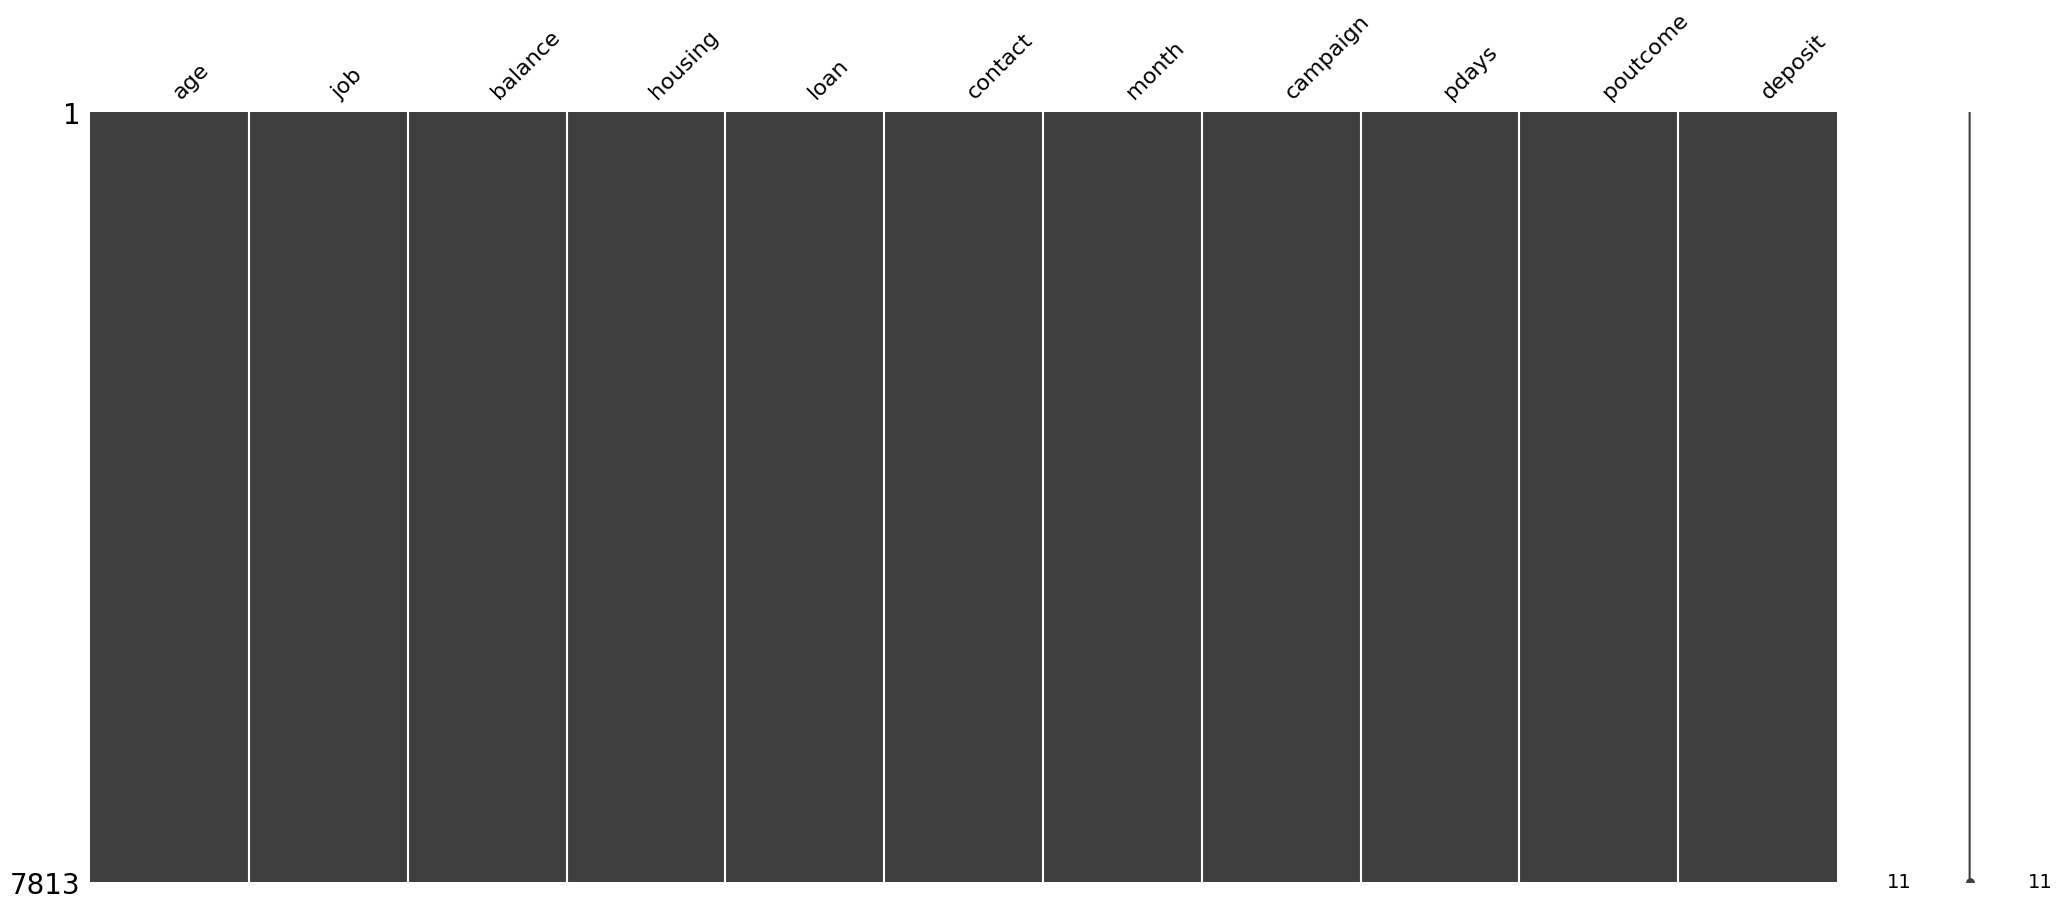

In [ ]:
import missingno

# Hubungan antar missing values secara visualisasi
missingno.matrix(df)

## Data Duplikat

Mengecek jumlah duplikat dalam dataset

In [ ]:
# jumlah yang duplikat
df.duplicated().sum()

np.int64(8)

## Variable Numerik

### Statistika Deskriptif

Menampilkan ringkasan statistik deskriptif untuk data numerik pada dataset.

In [ ]:
# Statistika dekriptif
df.describe()

,age,balance,campaign,pdays
count,7813.000000,7813.000000,7813.000000,7813.000000
mean,41.257264,1512.448611,2.519775,51.408550
std,11.919710,3089.291831,2.727001,108.072739
min,18.000000,-6847.000000,1.000000,-1.000000
25%,32.000000,127.000000,1.000000,-1.000000
50%,39.000000,549.000000,2.000000,-1.000000
75%,49.000000,1684.000000,3.000000,40.000000
max,95.000000,66653.000000,63.000000,854.000000


### Distribusi Data

Menampilkan/Menghitung jumlah kolom/fitur/variable numerik dalam dataset

In [ ]:
len(df.select_dtypes(include = 'number').columns)

4

Visualisasi dalam bentuk histogram untuk setiap kolom numerik dalam dataset.

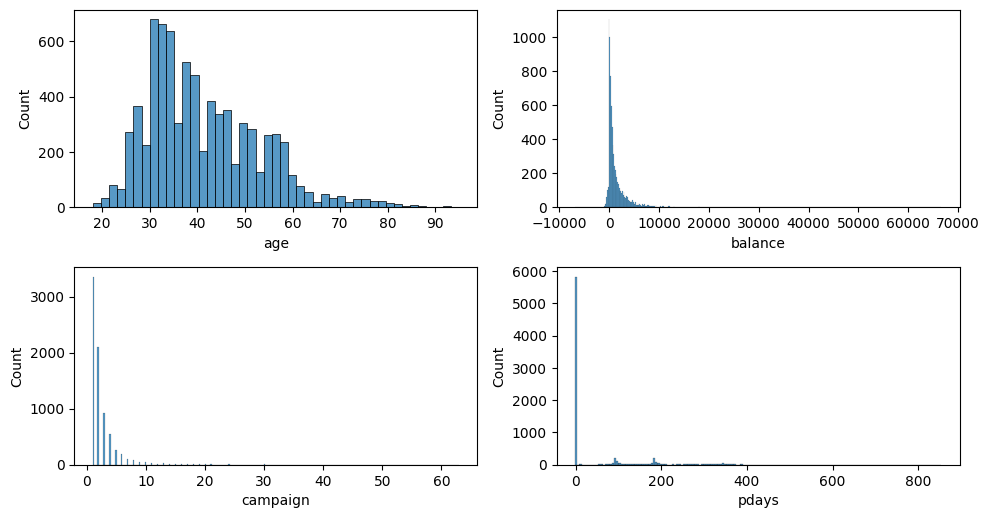

In [ ]:
numerik = df.select_dtypes(include = 'number')

# ganti ukuran pigura (wadah grafik nya)
plt.figure(figsize = (10,10))

posisi = 1 # menginisiasi posisi mulai dari 1
for setiap_kolom in numerik.columns: # numerik.columns = nama-nama kolom dalam list
    plt.subplot(4,2,posisi)
    sns.histplot(df[setiap_kolom])
    posisi = posisi + 1
    # agar tidak bertumpuk
    plt.tight_layout()

Histogramnya menunjukkan bahwa distribusi `age` relatif normal namun sekitar condong ke arah kanan atau *right skewed*, sedangkan `balance`, `campaign`, dan `pdays` terdistribusi sangat-condong kekanan dengan sebagian besar nilai berada di rentang rendah.

### Outliers

Membuat boxplot untuk setiap kolom numerik pada dataset guna mendeteksi adanya outlier.

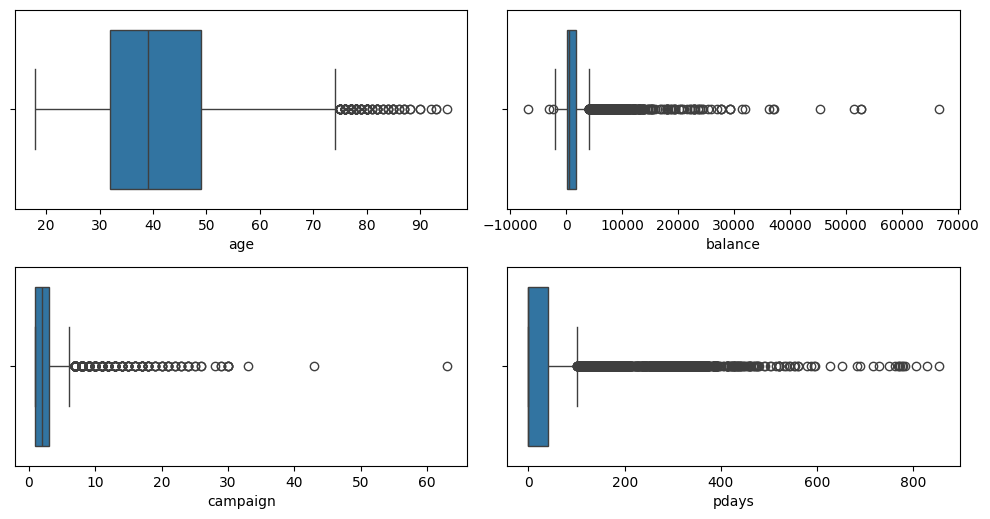

In [ ]:
numerik = df.select_dtypes(include = 'number')

# ganti ukuran pigura (wadah grafik nya)
plt.figure(figsize = (10,10))

posisi = 1 # menginisiasi posisi mulai dari 1
for setiap_kolom in numerik.columns: # numerik.columns = nama-nama kolom dalam list
    plt.subplot(4,2,posisi)
    sns.boxplot(x = df[setiap_kolom])
    posisi = posisi + 1
    # agar tidak bertumpuk
    plt.tight_layout()

Boxplot menginformasikan bahwa sebagian besar variabel (`balance`, `campaign`, dan `pdays`) memiliki banyak outliernya di sisi kanan, sedangkan `age` hanya memiliki sedikitnya di sisi kanan. Mayoritas data berada di dalam interkuartil range (IQR), tetapi distribusi data telah terlalu condong ke kanan.

### Korelasi

Menampilkan heatmap untuk melihat kekuatan hubungan antar kolom numerik, dihitung menggunakan korelasi **Spearman**, dengan nilai korelasi ditampilkan pada setiap kotak.

<Axes: >

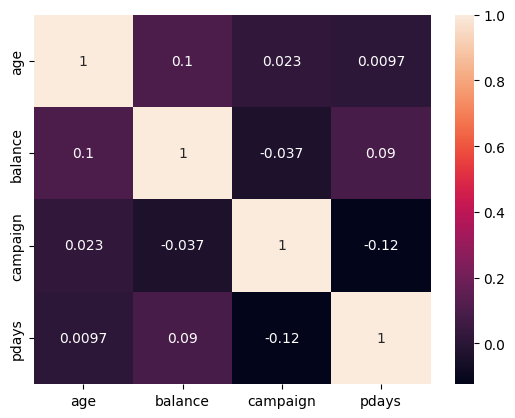

In [ ]:
sns.heatmap(numerik.corr(method = 'spearman'), annot = True)

Hasil heatmap ini menyatakan bahwa korelasi antara kolom numerik pada data sangat lemah, karena nilai korelasinya mendekati nol. Misalnya, korelasi antara `age` dan `balance` tidak lebih dari sekitar 0.10, sedangkan yang terkuat pun di sini masih jauh dari ±0.3, yang berarti tidak ada korelasi linear atau monotoni yang signifikan antar variabel numerik.

### Multikolinearitas dengan VIF

Membuat fungsi untuk menghitung **Variance Inflation Factor (VIF)** dari setiap kolom pada data, yang digunakan untuk mendeteksi multikolinearitas antar variabel independen.

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# buat function
def calc_vif(x):
    # dataframe kosong
    vif = pd.DataFrame()
    vif['variables'] = x.columns
    # menghitung vig untuk setiap kolom nya
    vif['VIF'] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
    return vif

Mengubah kolom `deposit` menjadi nilai numerik (0 untuk "no" dan 1 untuk "yes").

In [ ]:
df['deposit'] = df['deposit'].map({'no': 0, 'yes': 1})

Menghitung nilai VIF untuk semua kolom numerik kecuali `deposit`, dan mengurutkannya dari yang VIF-nya paling tinggi hingga terendah.

In [ ]:
numerik = df.select_dtypes(include='number')
calc_vif(numerik.drop(columns = 'deposit')).sort_values(by = 'VIF', ascending = False)

,variables,VIF
0,age,2.251170
2,campaign,1.749270
1,balance,1.250455
3,pdays,1.214082


Mengubah kembali nilai deposit menjadi kategorikal untuk keperluan EDA

In [ ]:
df['deposit'] = df['deposit'].map({0: 'no', 1: 'yes'})

## Variabel Kategorik

### Describe

Menampilkan ringkasan statistik deskriptif untuk semua kolom bertipe data object (kategori atau teks).

In [ ]:
df.describe(include = 'object')

,job,housing,loan,contact,month,poutcome,deposit
count,7813,7813,7813,7813,7813,7813,7813
unique,12,2,2,3,12,4,2
top,management,no,no,cellular,may,unknown,no
freq,1792,4140,6789,5628,1976,5819,4081


Sebagian besar nasabah bekerja di bidang **management** (1.789 orang), tidak memiliki pinjaman rumah maupun pinjaman pribadi. Kontak paling sering dilakukan lewat **cellular**, bulan **Mei** jadi yang paling banyak terjadi kontak, dan sebagian besar nasabah belum pernah mengikuti program pemasaran sebelumnya (**unknown**).

### Unique Values

Menampilkan jumlah nilai unik di setiap kolom kategori.

In [ ]:
kategorik = df.select_dtypes(include = 'object')
kategorik.nunique()

,0
job,12
housing,2
loan,2
contact,3
month,12
poutcome,4
deposit,2


### Value Counts

Menampilkan kategori yang paling sering muncul pada setiap kolom bertipe kategori dalam bentuk grafik batang horizontal.

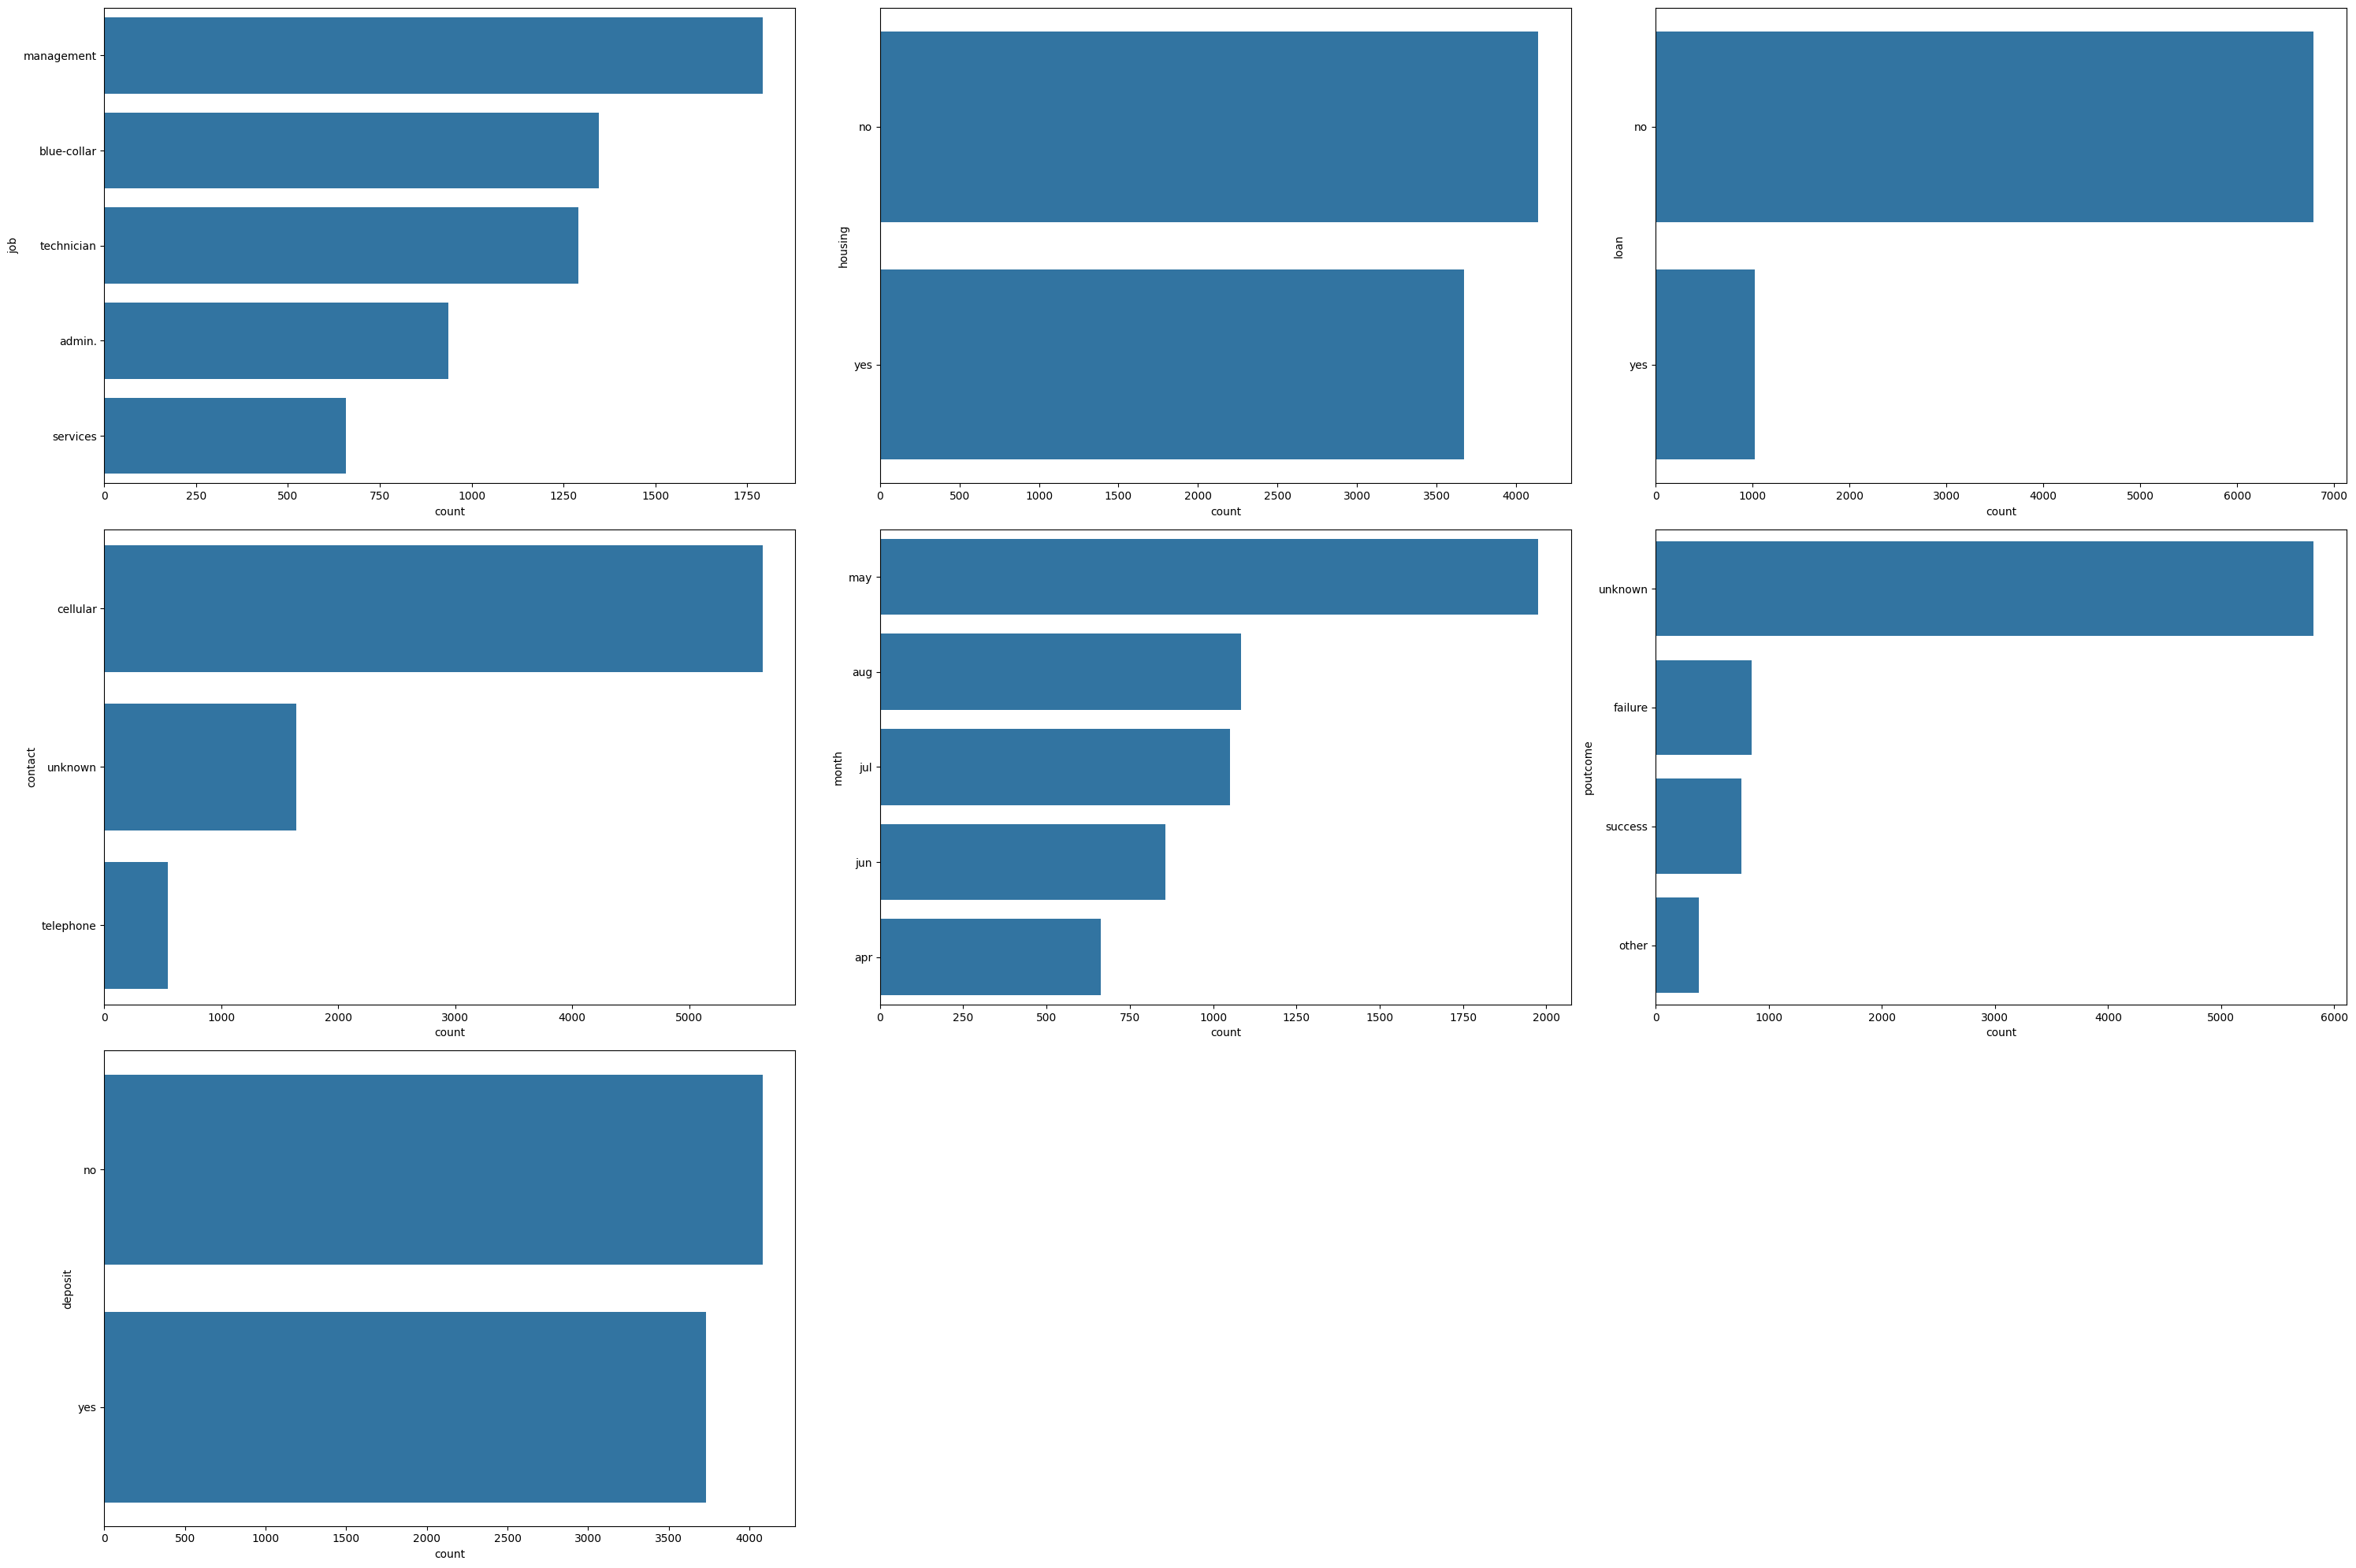

In [ ]:
# ganti ukuran pigura (wadah grafik nya)
plt.figure(figsize = (30,20)) # (horizontal, vertikal)

posisi = 1 # menginisiasi posisi mulai dari 1
for setiap_kolom in kategorik.columns: # kategorik.columns = nama-nama kolom dalam list
    plt.subplot(3,3,posisi)
    sns.barplot(df[setiap_kolom].value_counts().head(5), orient = 'h')
    posisi = posisi + 1
    # agar tidak bertumpuk
    plt.tight_layout()

Grafik menampilkan kategori yang paling sering muncul di setiap kolom kategori. Misalnya, pada kolom `job`, pekerjaan “management” adalah yang paling banyak, sedangkan di kolom `housing` lebih banyak yang menjawab “no”. Di kolom `loan`, mayoritas responden tidak memiliki pinjaman.

Beberapa kategori seperti `contact` didominasi oleh “cellular”, sedangkan `month` paling banyak terjadi di bulan Mei. Untuk `poutcome`, sebagian besar bernilai “unknown”, dan pada `deposit`, lebih banyak yang tidak melakukan deposit dibanding yang melakukan.


# Data Cleaning

## Handling Duplicate Data

Menghapus data duplikat (8 data) dengan di drop atau hapus barisnya.

In [ ]:
# mendrop data dupliat
df.drop_duplicates(inplace = True)

# Cek apakah data duplikat masih ada
df.duplicated().sum()

np.int64(0)

# EDA (Exploratory Data Analysis)


## Analisis Bivariate

### Hubungan Fitur Numerik dengan Target `deposit`

Membuat beberapa boxplot untuk membandingkan distribusi setiap variabel numerik berdasarkan status `deposit`.

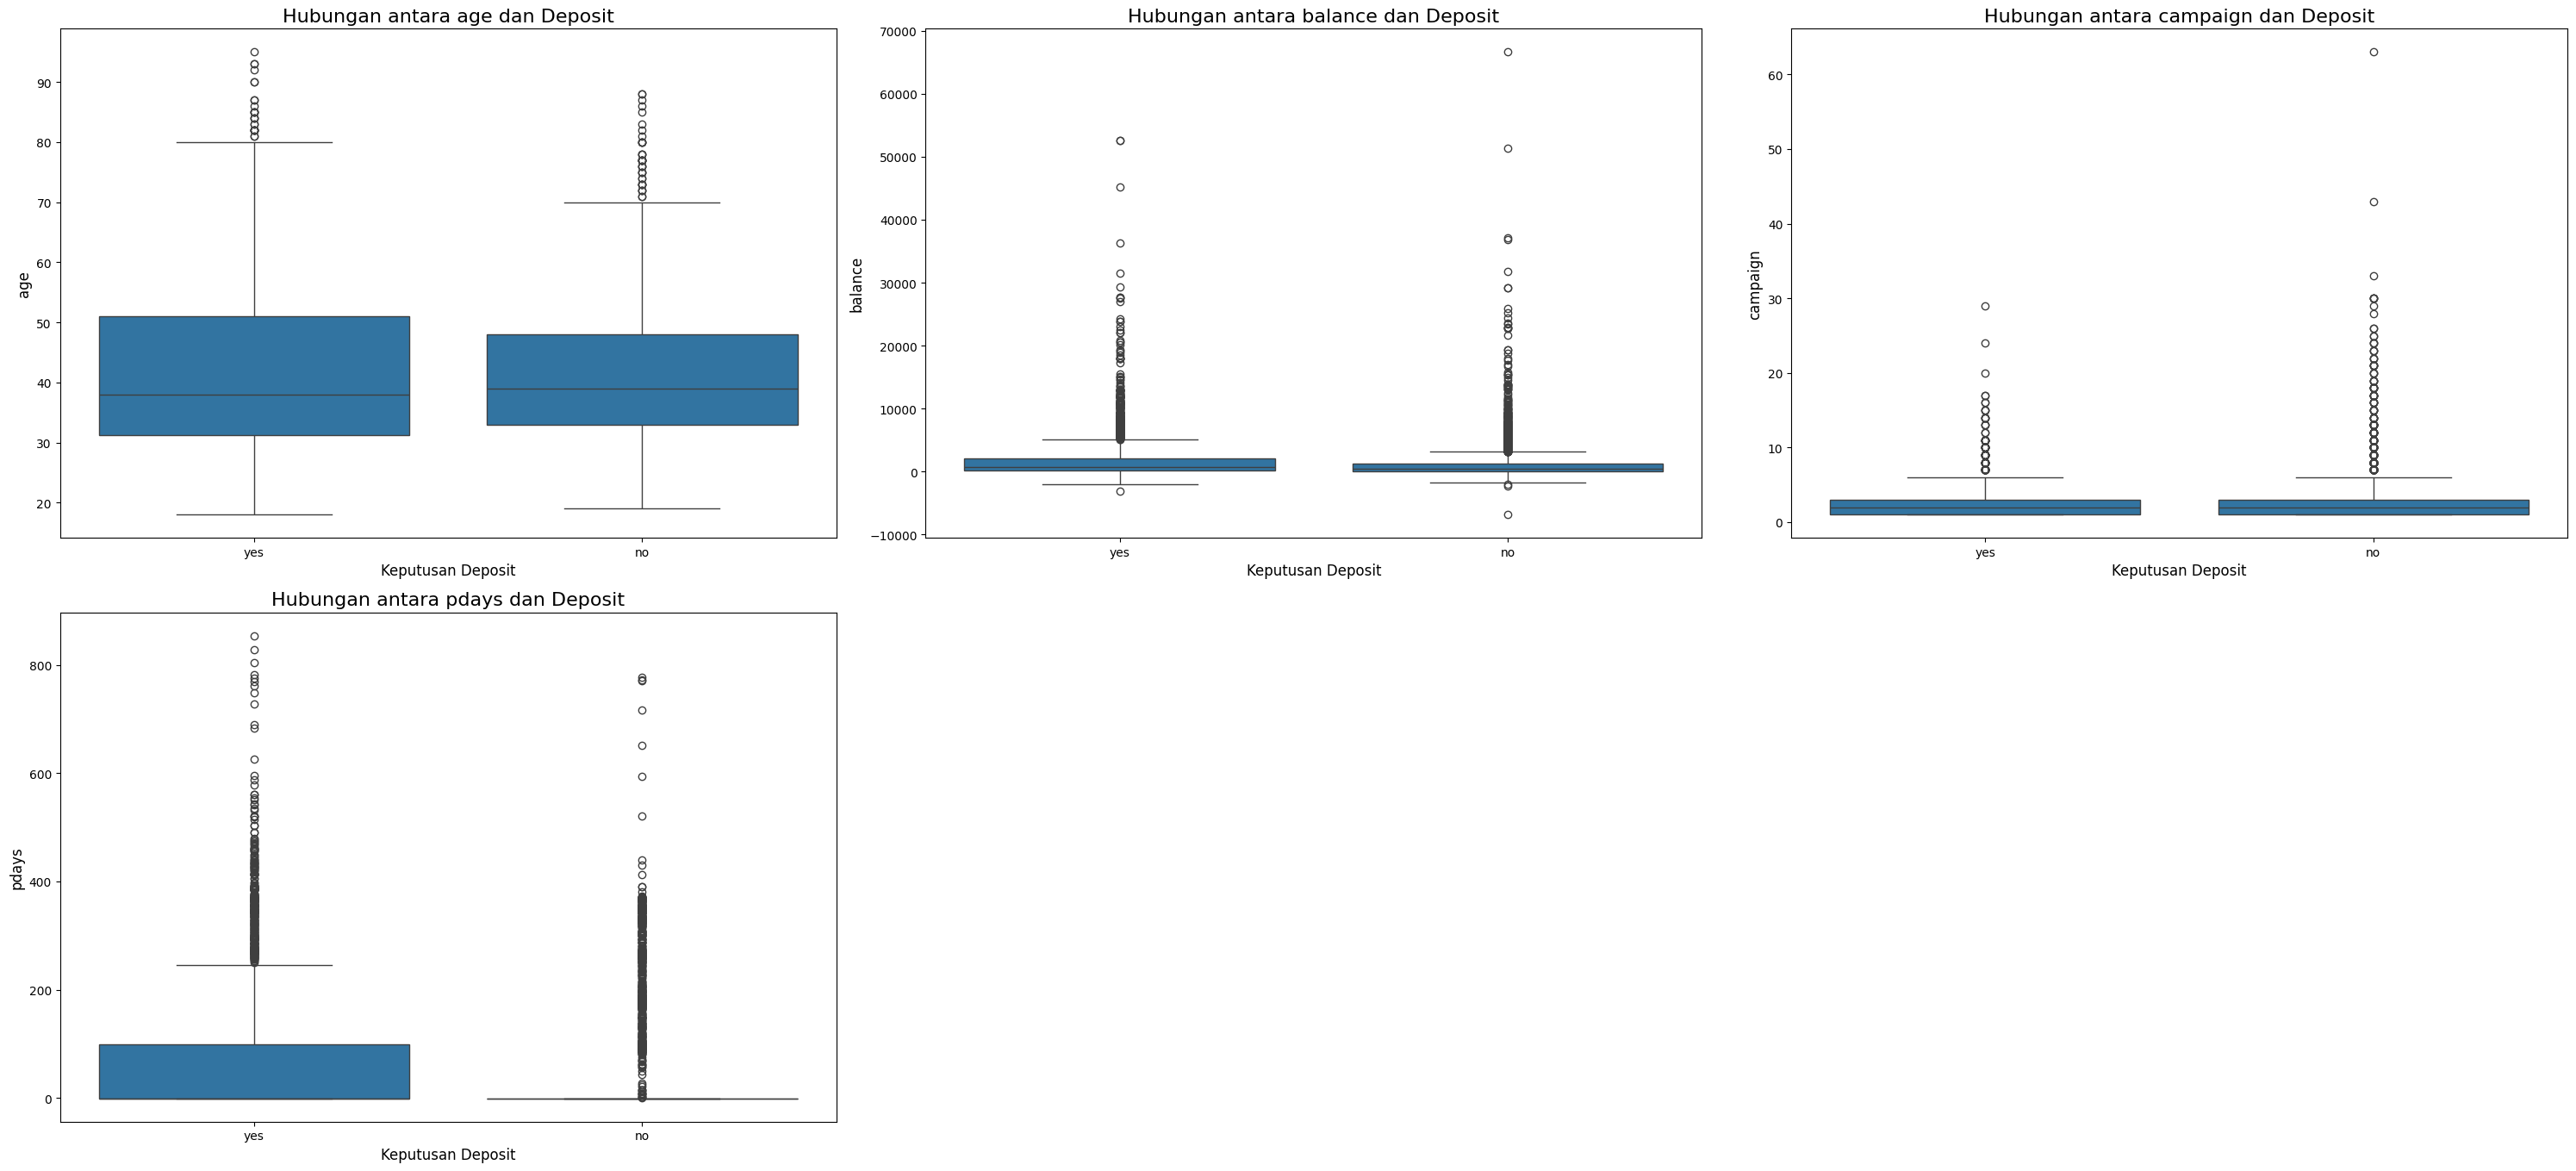

In [ ]:
numerik = df.select_dtypes(include = 'number')

plt.figure(figsize=(30, 20))
posisi = 1

for col in numerik:
    plt.subplot(3, 3, posisi)
    sns.boxplot(x='deposit', y=col, data=df)
    plt.title(f'Hubungan antara {col} dan Deposit', fontsize=16)
    plt.xlabel('Keputusan Deposit', fontsize=12)
    plt.ylabel(col, fontsize=12)
    posisi += 1

plt.tight_layout()
plt.show()

Dari hasil visualisasi dapat disimpulkan:

1.   Analisis Usia (`Age`) : Meskipun distribusi usia nasabah yang deposit dan yang tidak cukup mirip, nasabah yang melakukan deposit ('yes') cenderung memiliki usia median yang sedikit lebih tua.
2.   Analisis Saldo (`Balance`) : Nasabah yang memutuskan untuk melakukan deposit ('yes') secara jelas cenderung memiliki saldo (balance) rata-rata yang lebih tinggi dibandingkan dengan mereka yang tidak.
3.   Jumlah Kontak (`Campaign`) : Nasabah yang melakukan deposit ('yes') cenderung dihubungi dalam jumlah yang lebih sedikit selama kampanye ini, yang mengindikasikan bahwa terlalu banyak kontak bisa jadi tidak efektif
4.   Nasabah Lama vs. Nasabah Baru (`pdays`) : Nasabah yang pernah dihubungi pada kampanye sebelumnya (pdays > -1) menunjukkan kecenderungan yang jauh lebih tinggi untuk melakukan deposit dibandingkan nasabah yang belum pernah dihubungi sama sekali.

### Hubungan Fitur Kategorikal dengan Target `deposit`

Visualisasi Grafik batang untuk melihat perbandingan jumlah nasabah yang melakukan deposit dan yang tidak pada setiap kategori di semua kolom kategorikal.

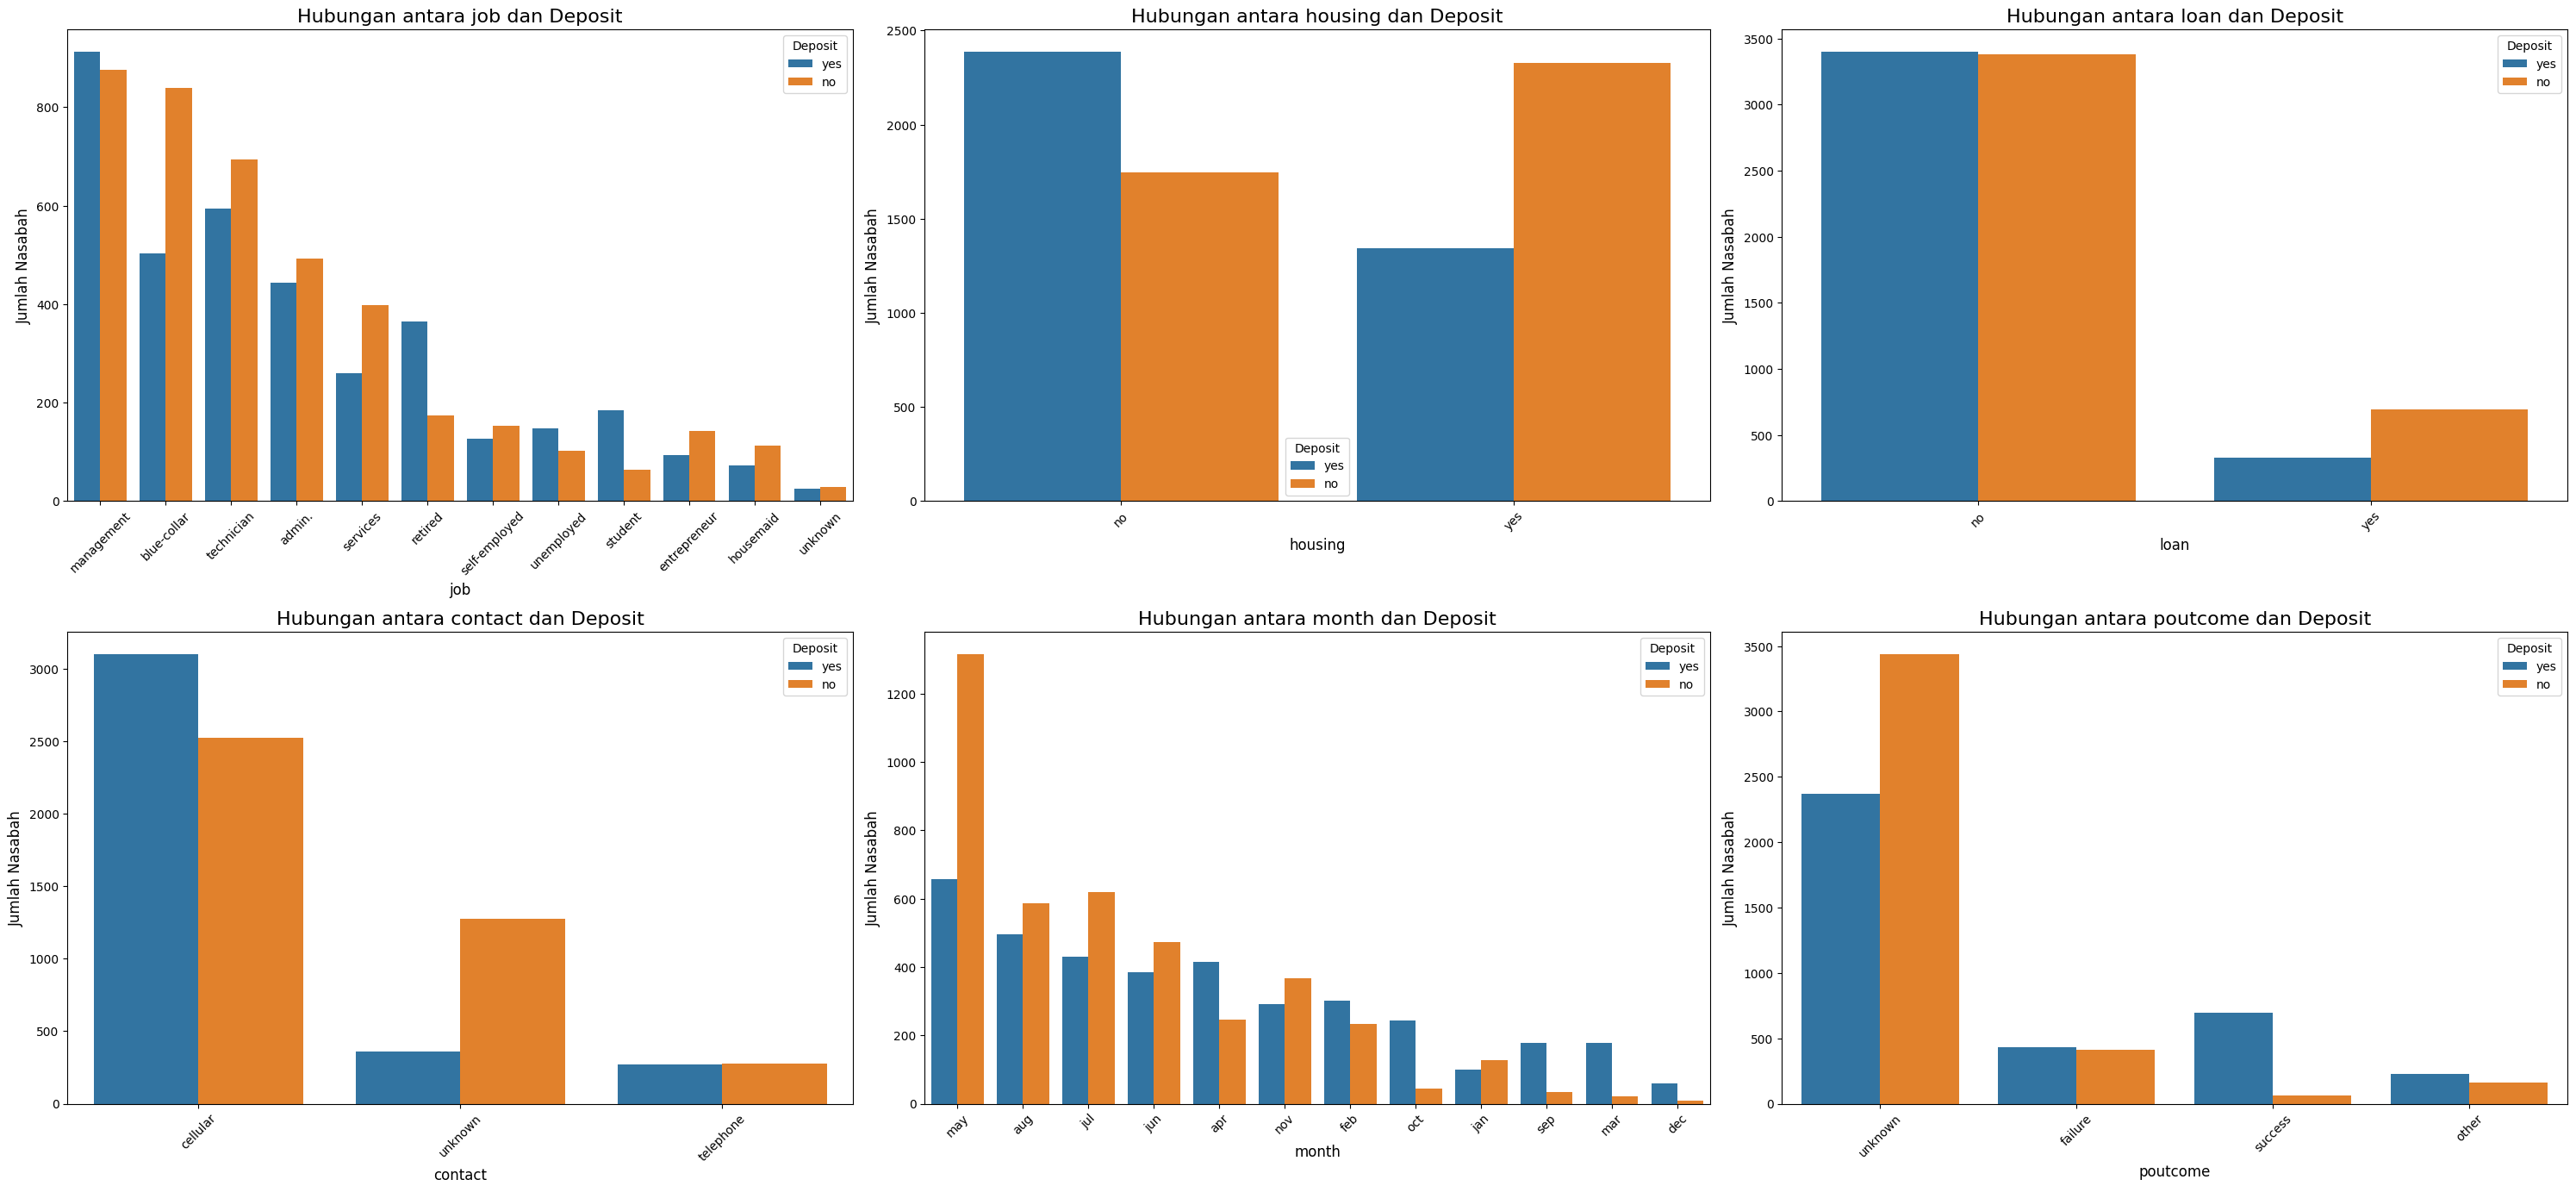

In [ ]:
categorical_features = [col for col in kategorik if col != 'deposit']

plt.figure(figsize=(30, 20))
posisi = 1

for col in categorical_features:
    plt.subplot(3, 3, posisi)
    sns.countplot(
        x=col,
        hue='deposit',
        data=df,
        order=df[col].value_counts().index
    )
    plt.title(f'Hubungan antara {col} dan Deposit', fontsize=16)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Jumlah Nasabah', fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(title='Deposit')
    posisi += 1

plt.tight_layout()
plt.show()


Dari hasil visualisasi dapat disimpulkan:

1.   Pekerjaan (`Job`) : Jenis pekerjaan nasabah tampaknya memengaruhi keputusan mereka, di mana nasabah dengan pekerjaan seperti 'management' dan 'technician' menunjukkan jumlah deposit tertinggi.
2.   Kredit Perumahan (`Housing`) : Nasabah yang tidak memiliki kredit perumahan ternyata lebih cenderung untuk setuju melakukan deposit.
3.   Hasil Kampanye Sebelumnya (`Poutcome`) : nasabah yang pada kampanye sebelumnya hasilnya sukses, hampir pasti akan melakukan deposit lagi pada kampanye ini.
4.   Pinjaman Pribadi (`Loan`) : Nasabah yang tidak memiliki pinjaman pribadi (loan = 'no') lebih besar kemungkinannya untuk melakukan deposit.
5. Jenis Kontak (`Contact`) : Menghubungi nasabah lewat telepon seluler (cellular) tampaknya jauh lebih efektif untuk mendapatkan deposit dibandingkan lewat telepon rumah (telephone).
6. Bulan Kontak (`Month`) : Tingkat kesuksesan kampanye sangat bergantung pada bulannya; bulan-bulan seperti Maret, September, Oktober, dan Desember menunjukkan rasio sukses yang jauh lebih tinggi dibandingkan bulan lainnya.


## Analisis Multivariate

Menampilkan heatmap yang menunjukkan seberapa kuat hubungan (korelasi) antar setiap fitur numerik dalam dataset.

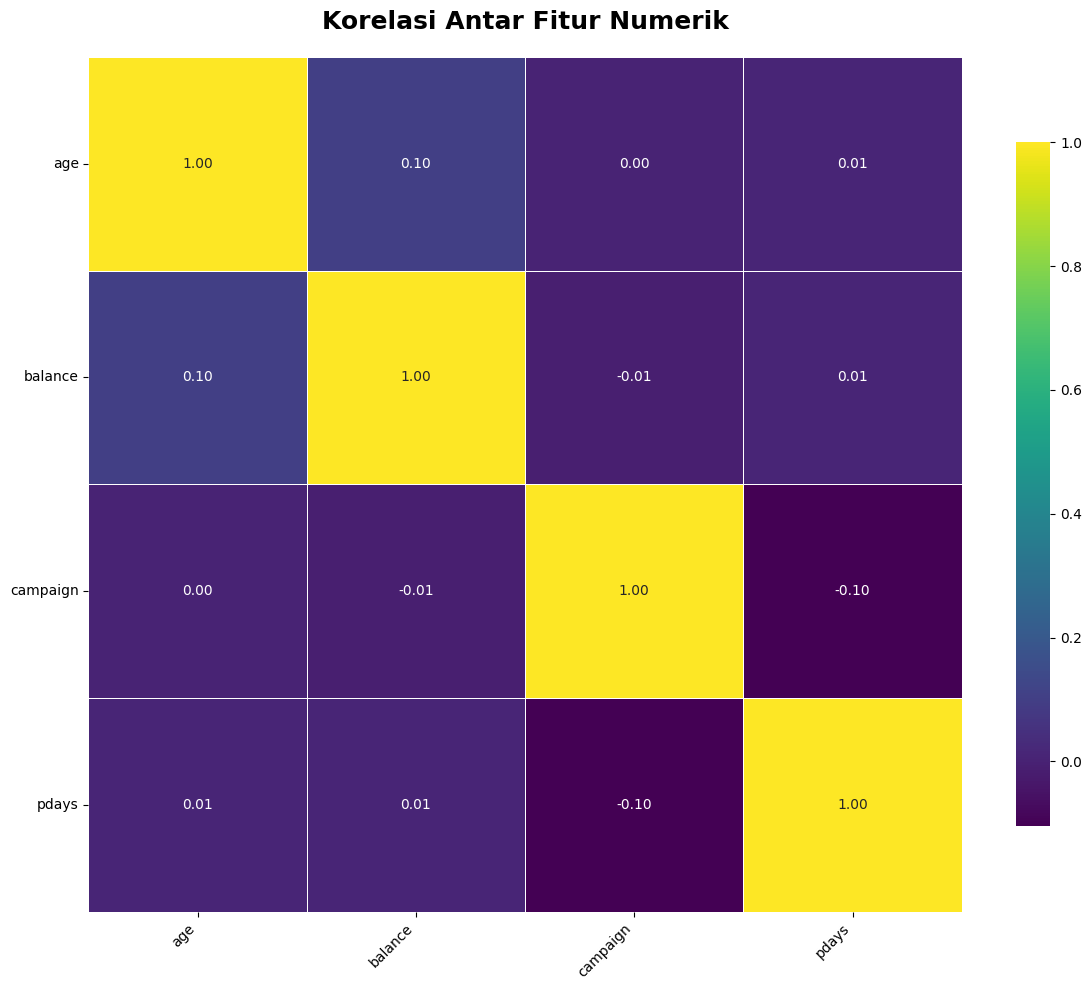

In [ ]:
# Heatmap Korelasi untuk fitur numerik
plt.figure(figsize=(12, 10))
correlation_matrix = df[numerik.columns].corr()

sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='viridis',
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={'shrink': 0.8}
)

plt.title('Korelasi Antar Fitur Numerik', fontsize=18, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

plt.show()

 Heatmap menunjukkan bahwa semua fitur numerik kita (seperti age, balance, dan campaign) berdiri sendiri dan tidak saling berhubungan erat satu sama lain.

## **Apa target atau output yang diharapkan setelah melakukan EDA**
>Target prediksi modelnya adalah kolom `deposit`. *Exploratory Data Analysis* (**EDA**) dilakukan untuk memahami bagaimana fitur-fitur lain (seperti `age`, `balance`, `poutcome`, dll.) berhubungan dengan dan memengaruhi target `deposit` ini. Hasil pemahaman dari **EDA** kemudian digunakan untuk membangun model yang lebih baik dalam memprediksi nilai pada kolom `deposit`.

# Data Splitting

Data dipisahkan menjadi dua bagian: satu berisi semua fitur yang digunakan untuk memprediksi, dan satu lagi hanya berisi target deposit yang ingin diprediksi.

In [ ]:
X = df.drop(columns = 'deposit')
y = df['deposit']

Membagi data menjadi data latih dan data uji, dengan 80% untuk pelatihan dan 20% untuk pengujian, sambil memastikan proporsi kelas pada target deposit tetap seimbang.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.2,
    random_state = 42,
    stratify = y # JANGAN SAMPAI LUPA UNTUK KLASIFIKASI di stratify
)

Menampilkan ukuran atau jumlah baris dan kolom pada data latih dan data uji.

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6244, 10), (1561, 10), (6244,), (1561,))

Merubah label yes dan no menjadi 1 dan 0 untuk keperluan evaluasi

In [ ]:
y_train_num = y_train.map({'no': 0, 'yes': 1})
y_test_num = y_test.map({'no': 0, 'yes': 1})

# Data Preparation

Kolom kategori tertentu seperti `housing`, `loan`, `contact`, `month`, dan `poutcome` diubah menjadi angka dengan teknik one-hot encoding, kolom `job` diubah menggunakan binary encoding, sementara kolom numerik seperti `age`, `balance`, `campaign`, dan `pdays` diskalakan ke rentang 0–1.

In [ ]:
transformer = ColumnTransformer([
    ('onehot_bin', OneHotEncoder(drop='first'), ['housing', 'loan', 'contact', 'month', 'poutcome']),
    ('binary', BinaryEncoder(), ['job']),
    ('scaler', MinMaxScaler(), ['age', 'balance', 'campaign', 'pdays'])
], remainder='passthrough')
transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('onehot_bin', OneHotEncoder(drop='first'),
                                 ['housing', 'loan', 'contact', 'month',
                                  'poutcome']),
                                ('binary', BinaryEncoder(), ['job']),
                                ('scaler', MinMaxScaler(),
                                 ['age', 'balance', 'campaign', 'pdays'])])

# Modelling

## Experiment 1: Based Model

Model-model prediksi seperti logistic regression, decision tree, dan KNN digabungkan menggunakan teknik voting, stacking, bagging, dan boosting untuk meningkatkan keakuratan hasil prediksi.

In [ ]:
# base model
lr = LogisticRegression(max_iter = 1000)
dt = DecisionTreeClassifier(random_state=0)
knn = KNeighborsClassifier()

# voting
vc_hard = VotingClassifier([
    ('lr', lr),
    ('dt', dt),
    ('knn', knn)
    ], voting = 'hard')
vc_soft = VotingClassifier([
    ('lr', lr),
    ('dt', dt),
    ('knn', knn)
    ], voting = 'soft')

# stacking
base_model = ([
    ('lr', lr),
    ('dt', dt),
    ('knn', knn)
])
meta_model = LogisticRegression()
stacking = StackingClassifier(estimators=base_model, final_estimator=meta_model)

# bagging
rf = RandomForestClassifier(random_state=0)

# boosting
gb = GradientBoostingClassifier(random_state=0)
xgb = XGBClassifier(random_state=0)

Model-model dilatih dan diuji menggunakan teknik validasi silang untuk mengukur performa dengan skor F1, lalu hasilnya dibandingkan untuk melihat seberapa baik masing-masing model dalam memprediksi data baru.


In [ ]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import ADASYN

train_score_list = []
train_score_std_list = []
test_score_list = []

for model_instance in [lr, dt, knn, vc_hard, vc_soft, stacking, rf, gb, xgb]:
    model = Pipeline([
        ('transformer', transformer),
        ('model', model_instance)
    ])
    # Cross-validation dengan label numerik
    score = cross_val_score(model, X_train, y_train_num, cv=StratifiedKFold(n_splits=5), scoring='f1')
    train_score_list.append(score.mean())
    train_score_std_list.append(score.std())

    # Training model
    model.fit(X_train, y_train_num)
    ypred_test = model.predict(X_test)

    # Evaluasi dengan label numerik
    test_score = f1_score(y_test_num, ypred_test)
    test_score_list.append(test_score)


Tabel dibuat untuk menampilkan perbandingan hasil performa beberapa model berdasarkan skor rata-rata dan variasi saat pelatihan serta hasil pengujian, kemudian diurutkan dari yang terbaik.

In [ ]:
df1 = pd.DataFrame({
    'model': ['Logistic Regression', 'Decision Tree', 'KNN', 'VC Soft', 'VC Hard', 'Stacking', 'Random Forest', 'Gradient Boosting', 'XGBoost'],
    'train_score_mean': train_score_list,
    'train_score_std': train_score_std_list,
    'test_score': test_score_list}).sort_values(by = 'test_score', ascending = False)
df1

,model,train_score_mean,train_score_std,test_score
6,Random Forest,0.675538,0.007049,0.688920
7,Gradient Boosting,0.681244,0.012197,0.686434
8,XGBoost,0.665630,0.015331,0.678445
5,Stacking,0.663136,0.010620,0.662731
3,VC Soft,0.660715,0.008858,0.657249
0,Logistic Regression,0.643988,0.012456,0.654935
4,VC Hard,0.648583,0.013447,0.650652
2,KNN,0.647210,0.005917,0.628734
1,Decision Tree,0.616491,0.018511,0.623816


Hasil ini menunjukkan performa berbagai model dalam memprediksi data, di mana:

1. **Random Forest** memiliki skor F1 tertinggi pada data uji (0.689), artinya model ini paling akurat dan konsisten dalam memprediksi.
2. **Gradient Boosting** dan **XGBoost** juga menunjukkan hasil yang sangat baik dan hampir setara dengan Random Forest.
3. **Stacking** dan metode voting (VC Soft dan VC Hard) memberikan performa cukup baik, di atas Logistic Regression dan KNN.
4. **Logistic Regression** dan **VC Hard** memiliki performa menengah, sedangkan **KNN** dan **Decision Tree** menunjukkan hasil paling rendah dibanding model lainnya.
5. Standar deviasi skor pelatihan relatif kecil untuk sebagian besar model, menunjukkan hasil pelatihan cukup stabil dan tidak terlalu fluktuatif.

Secara keseluruhan, model ensemble seperti Random Forest, Gradient Boosting, dan XGBoost lebih unggul dalam kasus ini dibanding model tunggal seperti Decision Tree atau KNN.

## Experiment 2: Hapus Outliers

Menghapus semua baris pada DataFrame yang mengandung outlier di salah satu atau lebih kolom numerik, dengan cara mencari nilai outlier berdasarkan aturan IQR (Interquartile Range) dan kemudian menghapus baris tersebut dari data.

In [ ]:
def hapus_outliers_seluruhnya(df, target):
    kolom_numerik = df.drop(columns=target).select_dtypes(include='number').columns
    index_outliers = set()

    for kolom in kolom_numerik:
        q1 = df[kolom].quantile(0.25)
        q3 = df[kolom].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        # cari baris yang outlier di kolom ini
        outlier_idx = df[(df[kolom] < lower_bound) | (df[kolom] > upper_bound)].index
        index_outliers.update(outlier_idx)

    # hapus semua baris yang merupakan outlier di kolom mana pun
    return df.drop(index_outliers)


Menggabungkan fitur dan target pada data pelatihan menjadi satu dataset, lalu menghapus baris-baris yang mengandung outlier dari data pelatihan tersebut saja, tanpa mempengaruhi data pengujian.

In [ ]:
# Gabungkan X_train dan y_train dulu
train_set = X_train.copy()
train_set['deposit'] = y_train

# Hapus outliers hanya dari training set
train_set_no_outliers = hapus_outliers_seluruhnya(train_set, 'deposit')

### Mengecek Outliers

Visualisasi outlier dan distribusi data pada setiap kolom numerik

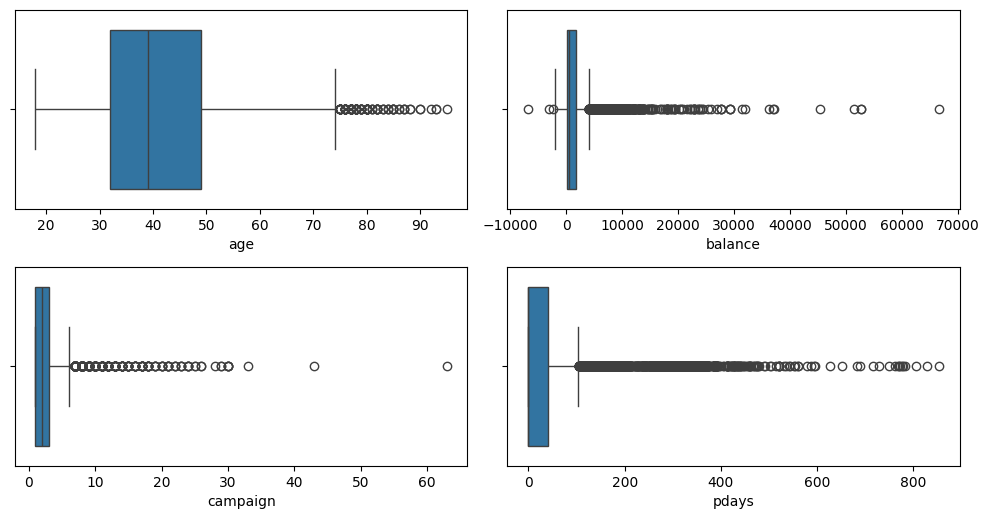

In [ ]:
numerik = df.select_dtypes(include = 'number')

# ganti ukuran pigura (wadah grafik nya)
plt.figure(figsize = (10,10))

posisi = 1 # menginisiasi posisi mulai dari 1
for setiap_kolom in numerik.columns: # numerik.columns = nama-nama kolom dalam list
    plt.subplot(4,2,posisi)
    sns.boxplot(x = df[setiap_kolom])
    posisi = posisi + 1
    # agar tidak bertumpuk
    plt.tight_layout()

Boxplot menginformasikan bahwa sebagian besar variabel (`balance`, `campaign`, dan `pdays`) memiliki banyak outliernya di sisi kanan, sedangkan `age` hanya memiliki sedikitnya di sisi kanan. Mayoritas data berada di dalam interkuartil range (IQR), tetapi distribusi data telah terlalu condong ke kanan.

Visualisasi boxplot untuk setiap kolom numerik dalam dataset train_set_no_outliers agar mudah melihat sebaran data dan outliernya.

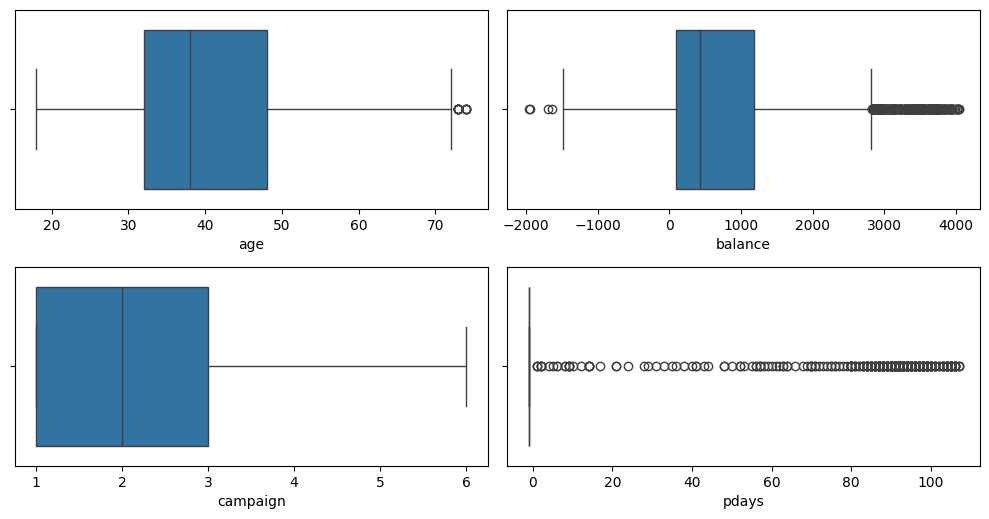

In [ ]:
# Tampilkan boxplot untuk verifikasi
import matplotlib.pyplot as plt
import seaborn as sns

numerik = train_set_no_outliers.select_dtypes(include='number')

plt.figure(figsize=(10,10))
posisi = 1
for kolom in numerik.columns:
    plt.subplot(4, 2, posisi)
    sns.boxplot(x = train_set_no_outliers[kolom])
    posisi += 1
    plt.tight_layout()

Jumlah outlier berkurang dibanding sebelumnya, karena data sudah dibersihkan. Pada variabel age, mayoritas berada di usia 30–50 tahun dengan sedikit outlier di atas 70 tahun. Balance masih memiliki sedikit nilai ekstrem di bawah -1000 dan di atas 3000, namun sebaran utamanya lebih rapat di sekitar 0–2000. Campaign kini lebih terfokus di rentang 1–3 kali kontak, tanpa outlier yang terlalu jauh. Sedangkan pdays masih menunjukkan banyak nilai ekstrem di seluruh rentang atas (sekitar di atas 20 hari), menandakan pola kontak yang jarang atau tidak merata.

Memisahkan kembali data yang sudah dibersihkan dari outlier menjadi **fitur** (`X`) dan **target** (`y`), lalu membaginya menjadi data latih dan data uji dengan perbandingan 80:20, menggunakan `stratify` agar proporsi kelas pada target `deposit` tetap seimbang di kedua set.


In [ ]:
# Pisahkan kembali
X_train_no_outliers = train_set_no_outliers.drop(columns='deposit')
y_train_no_outliers = train_set_no_outliers['deposit']

X_train_no_outliers, X_test_no_outliers, y_train_no_outliers, y_test_no_outliers = train_test_split(
    X_train_no_outliers,
    y_train_no_outliers,
    test_size = 0.2,
    random_state = 42,
    stratify = y_train_no_outliers
)

Menampilkan jumlah baris dan kolom dari data latih dan data uji setelah dibagi.

In [ ]:
X_train_no_outliers.shape, X_test_no_outliers.shape, y_train_no_outliers.shape, y_test_no_outliers.shape

((3427, 10), (857, 10), (3427,), (857,))

Marubah kembali kategori yes dan no dalam `deposit` menjadi numerik 1 dan 0.

In [ ]:
y_train_no_outliers = y_train_no_outliers.map({'no': 0, 'yes': 1})
y_test_no_outliers = y_test_no_outliers.map({'no': 0, 'yes': 1})

Latih kembali model dengan data yang sudah dibersihkan outliernya

In [ ]:
from imblearn.pipeline import Pipeline

train_score_list = []
train_score_std_list = []
test_score_list = []

for i in [lr, dt, knn, vc_soft, vc_hard, stacking, rf, gb, xgb]:
    model = Pipeline([
        ('transformer', transformer),
        ('model', i)
    ])
    # Train model
    score = cross_val_score(model, X_train_no_outliers, y_train_no_outliers, cv = StratifiedKFold(n_splits = 5), scoring = 'f1')
    # menghitung mean f1 score setiap split
    train_score_list.append(score.mean())
    # menghitung standar deviasi
    train_score_std_list.append(score.std())

    # Prediksi
    model.fit(X_train_no_outliers, y_train_no_outliers)
    ypred_test = model.predict(X_test_no_outliers)

    # Evaluasi
    test_score = f1_score(y_test_no_outliers, ypred_test)
    test_score_list.append(test_score)

Tampilkan kembali model yang sudah dilatih dengan data yang tidak ada outliernya.

In [ ]:
df2 = pd.DataFrame({
    'model': ['Logistic Regression', 'Decision Tree', 'KNN', 'VC Soft', 'VC Hard', 'Stacking', 'Random Forest', 'Gradient Boosting', 'XGBoost'],
    'train_score_mean': train_score_list,
    'train_score_std': train_score_std_list,
    'test_score': test_score_list}).sort_values(by = 'test_score', ascending = False)
df2

,model,train_score_mean,train_score_std,test_score
7,Gradient Boosting,0.613373,0.025302,0.676218
0,Logistic Regression,0.601576,0.015703,0.657102
5,Stacking,0.614572,0.018243,0.652047
8,XGBoost,0.609752,0.016059,0.647462
3,VC Soft,0.603504,0.005936,0.646154
4,VC Hard,0.616400,0.009809,0.644979
6,Random Forest,0.610764,0.020753,0.637119
2,KNN,0.607571,0.015531,0.614743
1,Decision Tree,0.570353,0.012127,0.603960


Hasil pelatihan menunjukkan bahwa setelah outlier dihapus, hampir semua model mengalami penurunan nilai train_score_mean dan test_score. Sebelum penghapusan outlier, model seperti Random Forest dan Gradient Boosting mencapai F1 score pengujian di kisaran 0.68, tetapi setelah outlier dihapus, skor tertinggi hanya sekitar 0.67 dan sebagian besar model turun 1–4 poin. Hal ini bisa terjadi karena tidak semua outlier bersifat “noise”; sebagian mungkin mengandung informasi penting atau pola khusus yang membantu model membedakan kelas. Dengan menghapusnya, variasi data berkurang sehingga model kehilangan sinyal yang berguna, terutama pada algoritma berbasis pohon yang cukup tahan terhadap outlier. Akibatnya, meskipun data jadi “lebih bersih”, kemampuan generalisasi justru menurun.

## Experiment 3: Resampling for Balencing

Menghitung persentase kemunculan masing-masing kelas (0 dan 1) pada variabel target y_train sehingga kita bisa melihat apakah data latih seimbang atau tidak.

In [ ]:
# Persentase 0 dan 1
persentasey = y_train.value_counts(normalize = True)
persentasey

,proportion
deposit,
no,0.522101
yes,0.477899


Hasilnya menunjukkan bahwa di data latih, kelas **0** (tidak deposit) berjumlah sekitar **52,21%** dan kelas **1** (deposit) sekitar **47,78%**, sehingga dataset relatif seimbang dan tidak mengalami masalah ketidakseimbangan kelas yang signifikan. Meskipun begitu, penyeimbangan kelas akan tetap dilakukan guna mencoba apakah setelah kelasnya sangat seimbang akurasinya bisa naik atau tidak.

Melatih kembali model-model dengan menambahkan langkah penyeimbangan kelas menggunakan SMOTE agar proporsi data kelas 0 dan 1 menjadi seimbang sebelum proses training.

In [ ]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

train_score_list = []
train_score_std_list = []
test_score_list = []

for i in [lr, dt, knn, vc_hard, vc_soft, stacking, rf, gb, xgb]:
    model = Pipeline([
        ('transformer', transformer),
        ('balencing', SMOTE()),
        ('model', i)
    ])
    # Train model
    score = cross_val_score(model, X_train, y_train_num, cv = StratifiedKFold(n_splits = 5), scoring = 'f1')
    # menghitung mean f1 score setiap split
    train_score_list.append(score.mean())
    # menghitung standar deviasi
    train_score_std_list.append(score.std())

    # Prediksi
    model.fit(X_train, y_train_num)
    ypred_test = model.predict(X_test)

    # Evaluasi
    test_score = f1_score(y_test_num, ypred_test)
    test_score_list.append(test_score)

Menampilkan kembali akurasi model setelah kelas diseimbangkan.

In [ ]:
df3 = pd.DataFrame({
    'model': ['Logistic Regression', 'Decision Tree', 'KNN', 'VC Soft', 'VC Hard', 'Stacking', 'Random Forest', 'Gradient Boosting', 'XGBoost'],
    'train_score_mean': train_score_list,
    'train_score_std': train_score_std_list,
    'test_score': test_score_list}).sort_values(by = 'test_score', ascending = False)
df3

,model,train_score_mean,train_score_std,test_score
7,Gradient Boosting,0.687504,0.014294,0.694227
5,Stacking,0.670814,0.007113,0.686755
6,Random Forest,0.672341,0.012927,0.679406
3,VC Soft,0.669574,0.008169,0.672257
8,XGBoost,0.669851,0.015339,0.667128
4,VC Hard,0.649670,0.012264,0.666667
0,Logistic Regression,0.658612,0.007392,0.664731
2,KNN,0.649624,0.006098,0.638621
1,Decision Tree,0.606519,0.018349,0.607882


Hasil pelatihan menunjukkan bahwa penerapan **SMOTE** membuat sebagian model mengalami sedikit peningkatan performa, terutama pada **Gradient Boosting** (test score naik dari 0.6864 menjadi 0.6942) dan **Random Forest** (dari 0.6889 menjadi 0.6867). Model lain seperti **Stacking** dan **VC Soft** juga mendapat kenaikan kecil, sedangkan beberapa model seperti **Decision Tree** justru turun cukup signifikan. Peningkatan pada beberapa algoritma menunjukkan bahwa penyeimbangan kelas membantu model menangkap pola pada kelas minoritas dengan lebih baik, sehingga skor F1 keseluruhan naik. Namun, efek SMOTE tidak merata—pada model yang sebelumnya sudah cukup baik menangani distribusi kelas, oversampling malah bisa menambah noise dan menurunkan akurasi. Secara keseluruhan, SMOTE memberi dampak positif tipis pada model berbasis ensemble, tapi kurang menguntungkan untuk model sederhana seperti Decision Tree.

## Experiment 4: Resampling with Feature Selection

Features Selection untuk kolom yang berhubungan dengan deposit (bisa dilihat saat EDA)

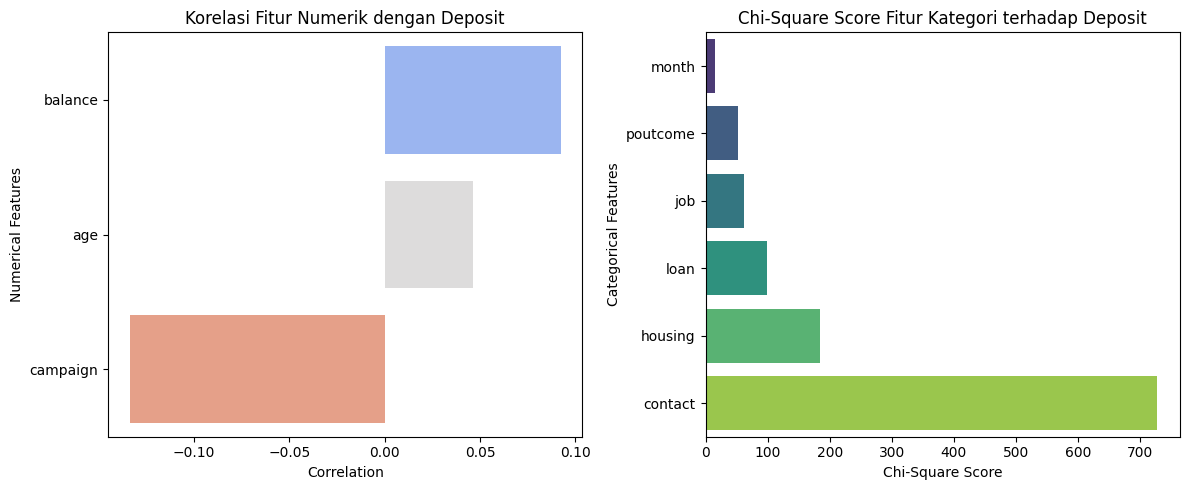

In [ ]:
# Pisahkan numerik dan kategori
num_cols = ["balance", "age", "campaign"]
cat_cols = ["month", "contact", "poutcome", "job", "housing", "loan"]

# Korelasi untuk numerik
corr_scores = df[num_cols].corrwith(y.map({'yes':1, 'no':0}))

# Chi-Square untuk kategori
le = LabelEncoder()
X_cat_encoded = df[cat_cols].apply(le.fit_transform)
chi_scores, _ = chi2(X_cat_encoded, y.map({'yes':1, 'no':0}))
chi_series = pd.Series(chi_scores, index=cat_cols).sort_values(ascending=True)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Korelasi numerik
sns.barplot(
    x=corr_scores.values,
    y=corr_scores.index,
    hue=corr_scores.index,
    palette="coolwarm",
    legend=False,
    ax=axes[0]
)
axes[0].set_title("Korelasi Fitur Numerik dengan Deposit")
axes[0].set_xlabel("Correlation")
axes[0].set_ylabel("Numerical Features")

# Plot 2: Chi-Square kategori
sns.barplot(
    x=chi_series.values,
    y=chi_series.index,
    hue=chi_series.index,
    palette="viridis",
    legend=False,
    ax=axes[1]
)
axes[1].set_title("Chi-Square Score Fitur Kategori terhadap Deposit")
axes[1].set_xlabel("Chi-Square Score")
axes[1].set_ylabel("Categorical Features")

plt.tight_layout()
plt.show()

Memilih fitur-fitur yang relevan bagi model

In [ ]:
selected_features = ["balance", "age", "month", "contact", "poutcome","job","housing","loan","campaign"]
X = df[selected_features]
y = df["deposit"]

Split lagi setelah feature selection

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.2,
    random_state = 42,
    stratify = y # JANGAN SAMPAI LUPA UNTUK KLASIFIKASI di stratify
)

Cek kembali dimensi dataframe setelah feature selection

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6250, 9), (1563, 9), (6250,), (1563,))

Merubah kembali kategori yes dan no pada deposit menjadi 1 dan 0

In [ ]:
y_train_num = y_train.map({'no': 0, 'yes': 1})
y_test_num = y_test.map({'no': 0, 'yes': 1})

Encoding dan normalisasi kembali fitur-fitur yang dipilih.

In [ ]:
transformer = ColumnTransformer([
    ('onehot_bin', OneHotEncoder(drop='first'), ['contact', 'month', 'poutcome',"housing","loan"]),
    ('binary', BinaryEncoder(), ['job']),
    ('scaler', MinMaxScaler(), ['age', 'balance', 'campaign'])
], remainder='passthrough')
transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('onehot_bin', OneHotEncoder(drop='first'),
                                 ['contact', 'month', 'poutcome', 'housing',
                                  'loan']),
                                ('binary', BinaryEncoder(), ['job']),
                                ('scaler', MinMaxScaler(),
                                 ['age', 'balance', 'campaign'])])

Latih kembali model dengan data yang sudah melakukan feature selection

In [ ]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

train_score_list = []
train_score_std_list = []
test_score_list = []

for i in [lr, dt, knn, vc_hard, vc_soft, stacking, rf, gb, xgb]:
    model = Pipeline([
        ('transformer', transformer),
        ('balencing', SMOTE()),
        ('model', i)
    ])
    # Train model
    score = cross_val_score(model, X_train, y_train_num, cv = StratifiedKFold(n_splits = 5), scoring = 'f1')
    # menghitung mean f1 score setiap split
    train_score_list.append(score.mean())
    # menghitung standar deviasi
    train_score_std_list.append(score.std())

    # Prediksi
    model.fit(X_train, y_train_num)
    ypred_test = model.predict(X_test)

    # Evaluasi
    test_score = f1_score(y_test_num, ypred_test)
    test_score_list.append(test_score)

Tampilkan kembali hasil pelatihan model yang sudah melakukan feature selection

In [ ]:
df4 = pd.DataFrame({
    'model': ['Logistic Regression', 'Decision Tree', 'KNN', 'VC Soft', 'VC Hard', 'Stacking', 'Random Forest', 'Gradient Boosting', 'XGBoost'],
    'train_score_mean': train_score_list,
    'train_score_std': train_score_std_list,
    'test_score': test_score_list}).sort_values(by = 'test_score', ascending = False)
df4

,model,train_score_mean,train_score_std,test_score
7,Gradient Boosting,0.677321,0.011863,0.705370
0,Logistic Regression,0.652860,0.016694,0.685265
6,Random Forest,0.668356,0.010184,0.676116
5,Stacking,0.661411,0.011578,0.673669
3,VC Soft,0.654376,0.014024,0.670352
8,XGBoost,0.664249,0.017480,0.666194
2,KNN,0.642901,0.011277,0.641484
4,VC Hard,0.632888,0.014395,0.639511
1,Decision Tree,0.602217,0.014304,0.604997


Hasil **feature selection** jauh lebih sebagus sebelumnya karena proses ini memangkas beberapa fitur yang ternyata tidak menyimpan informasi penting bagi model dalam memprediksi keputusan deposit. Tujuannya adalah mengurangi noise dan menghindari overfitting.

Membandingkan hasil pelatihan model dari 4 skenario yaitu, base model, without outlier, resampling dan feature selection.

In [ ]:
df1['eksperimen'] = 'Based Model'
df2['eksperimen'] = 'Without Outliers'
df3['eksperimen'] = 'Resampling'
df4['eksperimen'] = 'Resampling with Feature Selection'

# penggabungan semua df score
df_gab = pd.concat([df1, df2, df3, df4], axis = 0)
df_gab = df_gab.set_index(['eksperimen','model'])

# highlight ke score terbaik
df_gab.style.highlight_max(subset = ['train_score_mean','test_score'],color = 'lightgreen', axis = 0).highlight_min(subset = ['train_score_std'],color = 'lightgreen', axis = 0)

1. **Based Model** (baseline, tanpa modifikasi data) → Model ensemble seperti Random Forest dan Gradient Boosting sudah memberi performa yang cukup tinggi, dengan test score tertinggi 0.6889 (Random Forest). Data asli masih mengandung outlier dan ketidakseimbangan kelas ringan, namun informasi yang lengkap membuat model dapat memanfaatkan seluruh variasi data.

2. **Without Outliers** → Setelah outlier dihapus, hampir semua model mengalami penurunan skor. Ini menandakan bahwa sebagian outlier justru mengandung pola yang membantu prediksi, terutama untuk model pohon yang relatif tahan terhadap nilai ekstrem.

3. **Resampling (SMOTE)** → Penyeimbangan kelas memberi dorongan performa, terutama pada model Stacking (test score naik menjadi 0.6867) dan Gradient Boosting (0.6942). Hal ini karena kelas minoritas mendapat representasi yang lebih baik, sehingga model lebih seimbang dalam mengenali kedua kelas.

4. **Resampling + Feature Selection** → Meningkatkan performa dibanding resampling saja. Skenario ini menghasilkan performa terbaik secara keseluruhan. Dengan mengombinasikan penyeimbangan data dan pemilihan fitur-fitur paling relevan, model Gradient Boosting berhasil mencapai skor tes puncak sebesar 0.7053, menjadikannya konfigurasi model final untuk proyek ini.

## Final Model dan Hyperparameter Tuning

In [ ]:
from imblearn.over_sampling import SMOTE

best_model = Pipeline([
    ('transformer', transformer),
    ('balancing', SMOTE()),
    ('model', gb)
])

param_grid_gb = {
    'model__n_estimators': [100, 200],
    'model__learning_rate': [0.05, 0.1],
    'model__max_depth': [3, 5]
}

gb_pipe = Pipeline([
    ('transformer', transformer),
    ('balancing', SMOTE()),
    ('model', GradientBoostingClassifier(random_state=0))
])

grid_gb = GridSearchCV(gb_pipe, param_grid_gb, cv=5, scoring='f1')
grid_gb.fit(X_train, y_train_num)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot_bin',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['contact',
                                                                          'month',
                                                                          'poutcome',
                                                                          'housing',
                                                                          'loan']),
                                                                        ('binary',
                                                                         BinaryEncoder(),
                                                                         ['job']),
                                                                        ('scaler',
                                                                         MinMaxScaler(),
                                                                         ['age',
                                                                          'balance',
                                                                          'campaign'])])),
                                       ('balancing', SMOTE()),
                                       ('model',
                                        GradientBoostingClassifier(random_state=0))]),
             param_grid={'model__learning_rate': [0.05, 0.1],
                         'model__max_depth': [3, 5],
                         'model__n_estimators': [100, 200]},
             scoring='f1')

In [ ]:
y_pred = grid_gb.predict(X_test)
print(classification_report(y_test_num, y_pred))
print(f'F1 Score: {f1_score(y_test_num, y_pred)}')

              precision    recall  f1-score   support

           0       0.72      0.82      0.76       816
           1       0.77      0.64      0.70       747

    accuracy                           0.74      1563
   macro avg       0.74      0.73      0.73      1563
weighted avg       0.74      0.74      0.73      1563

F1 Score: 0.7001455604075691


## Pemilihan Metode Preprocessing
> Dalam tahap persiapan data, beberapa metode kunci dipilih untuk memastikan data siap dan optimal untuk pemodelan. ***One-Hot Encoder*** digunakan untuk fitur-fitur seperti `month`, `poutcome`, `contact`, `housing` dan `loan` karena fitur-fitur ini **bersifat nominal** (tanpa tingkatan) dan jumlah kategorinya sedikit. Untuk fitur `job` yang memiliki lebih banyak kategori, ***Binary Encoder*** dipilih sebagai solusi yang lebih efisien untuk **merepresentasikan informasi tanpa menciptakan terlalu banyak kolom baru**. Terakhir, ***Min-Max Scaler*** diterapkan pada fitur-fitur numerik yaitu `age`, `balance` dan `campaign` untuk **mengubah skala nilainya ke rentang 0 hingga 1**, memastikan semua fitur memiliki bobot yang setara.

## Penggunaan SMOTE
>Berdasarkan analisis awal pada data, t**eridentifikasi adanya sedikit ketidakseimbangan** (*imbalance*) meski hanya sedikit antara jumlah nasabah yang melakukan `deposit` ('yes') dan yang tidak ('no'). Untuk mencegah model menjadi bias dan cenderung memprediksi kelas mayoritas, **teknik oversampling SMOTE** (*Synthetic Minority Over-sampling Technique*) diterapkan. **SMOTE** dipilih karena kemampuannya untuk **menyeimbangkan distribusi kelas dengan cara membuat data sintetis dari kelas minoritas** (nasabah yang `deposit` 'yes'), sehingga model dapat mempelajari karakteristik kedua kelas secara lebih adil dan komprehensif.

## Pemilihan Model dan Hyperparameter Tuning

Dari sembilan model yang diuji menggunakan *cross-validation*, ***Gradient Boosting*** secara konsisten **menunjukkan performa F1-score tertinggi pada data latih dan data uji**, dengan **skor 0.705**. Algoritma ini dipilih karena sifatnya sebagai model ensemble yang kuat, yang secara iteratif memperbaiki kesalahan dari model-model sebelumnya untuk membangun sebuah prediktor yang sangat akurat. Untuk lebih **mengoptimalkan performanya**, ***GridSearchCV*** digunakan untuk melakukan hyperparameter tuning. Metode ini dipilih karena kemampuannya untuk secara sistematis **menguji berbagai kombinasi hyperparameter** (seperti n_estimators dan max_depth) dan secara otomatis menemukan setelan terbaik yang menghasilkan F1-score tertinggi, memastikan model final yang kita dapatkan adalah versi terbaik dari Gradient Boosting.

# Final Model Interpretation

## Feature Importances

Mengurutkan fitur dari yang paling berpengaruh hingga yang paling rendah berdasarkan hasil model Gradient Boosting yang sudah dituning.

In [ ]:
# Ambil model terbaik dari GridSearchCV
best_pipe = grid_gb.best_estimator_

# Ambil feature importance
feat_imp = best_pipe.named_steps['model'].feature_importances_
features = best_pipe.named_steps['transformer'].get_feature_names_out()

# Buat DataFrame dan urutkan
df_feat_imp = pd.DataFrame({
    'features': features,
    'importance': feat_imp
}).sort_values(by='importance', ascending=False)

df_feat_imp

,features,importance
14,onehot_bin__poutcome_success,0.247575
1,onehot_bin__contact_unknown,0.182259
22,scaler__age,0.099299
23,scaler__balance,0.084346
24,scaler__campaign,0.074341
16,onehot_bin__housing_yes,0.069021
7,onehot_bin__month_jun,0.035556
17,onehot_bin__loan_yes,0.031608
15,onehot_bin__poutcome_unknown,0.030885
8,onehot_bin__month_mar,0.029096


Terlihat bahwa faktor poutcome_success (hasil kampanye sebelumnya sukses) adalah penentu paling kuat (24.7%), diikuti oleh contact_unknown (18.2%), lalu faktor numerik seperti balance (9.9%) dan age (8.4%). Nilai importance semakin kecil berarti kontribusinya terhadap prediksi juga semakin kecil.

Visualisasi dari feature importance untuk membaca data lebih mudah dan lebih menarik.

<Axes: xlabel='importance', ylabel='features'>

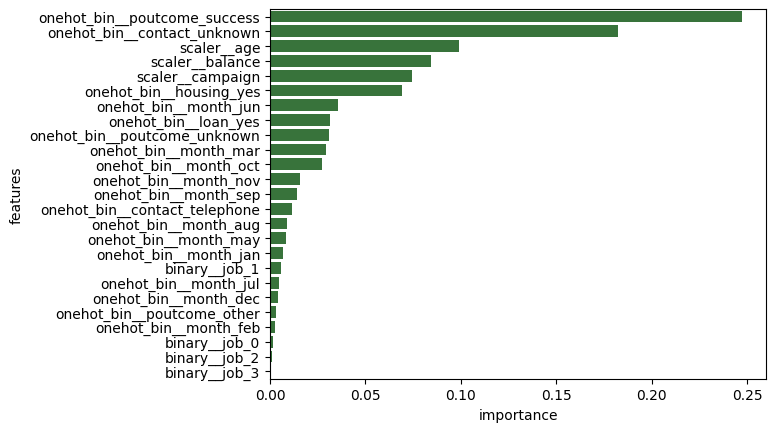

In [ ]:
sns.barplot(
    x='importance',
    y='features',
    data=df_feat_imp,
    color='#2e7d32'
)

### Kesimpulan dari Feature Importance
>Kesimpulan dari feature importance ini sangat jelas: riwayat interaksi nasabah adalah prediktor yang jauh lebih kuat daripada profil mereka. Fitur yang paling dominan adalah **poutcome_success** (`poutcome`), diikuti oleh **contact_unknown** (`contact`). Setelah itu, barulah faktor-faktor nasabah seperti `age`, `balance`, `campaign`, dan **housing_yes** (`housing`) menunjukkan pengaruh yang signifikan. Menariknya, fitur yang dianggap paling tidak berpengaruh oleh model adalah `job`, yang mengindikasikan bahwa riwayat kontak lebih penting daripada jenis pekerjaan nasabah.


## Limitasi

### Klasifikasi

## Estimasi Keuntungan

Confusion matrix untuk menguji keakuratan dan presisi dari masing-masing kelas.

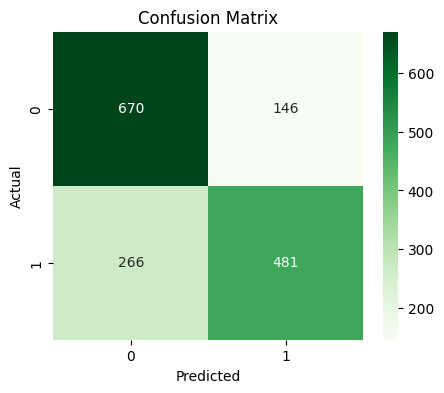

In [ ]:
cm = confusion_matrix(y_test_num, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Greens")  # hijau gelap → hijau muda
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Kesimpulan dan Rekomendasi


## Kesimpulan

Melalui serangkaian eksperimen, ***Gradient Boosting*** terbukti menjadi model paling efektif, yang berhasil mencapai **F1-Score 0.70** pada data uji setelah dioptimalkan. Kunci keberhasilan model ini terletak pada penerapan teknik ***SMOTE*** untuk mengatasi data tidak seimbang, ***Feature Selection*** untuk memilih fitur yang relevan dan ***Hyperparameter Tuning*** untuk mendapatkan setelan terbaik. Analisis feature importance juga mengonfirmasi sebuah temuan menarik: riwayat interaksi nasabah (`poutcome_success`) menjadi faktor penentu yang jauh lebih kuat daripada profil nasabah itu sendiri.

## Rekomendasi untuk model

Model Gradient Boosting dengan parameter hasil tuning saat ini disarankan digunakan untuk implementasi prediksi di produksi. Pemeliharaan model sebaiknya dilakukan secara berkala melalui retraining agar tetap adaptif terhadap perubahan pola nasabah. Selain itu, penyesuaian threshold atau penerapan metode calibration dapat dipertimbangkan untuk menyeimbangkan precision dan recall sesuai kebutuhan bisnis.

## Rekomendasi untuk bisnis

Berdasarkan hasil analisis, kampanye pemasaran sebaiknya difokuskan pada nasabah dengan riwayat kampanye sebelumnya yang sukses (poutcome_success), karena mereka memiliki kemungkinan lebih besar untuk berdeposit. Strategi komunikasi perlu memprioritaskan kontak melalui telepon seluler dan menghindari kategori contact_unknown yang cenderung kurang responsif. Selain itu, segmen nasabah dengan saldo tinggi dan usia matang (40–60 tahun) layak menjadi target utama, mengingat kecenderungan mereka yang lebih tinggi untuk melakukan deposit.

# Save Model

Save model dalam format pickle atau .pkl.

In [ ]:
import pickle

# Save model hasil tuning (GridSearchCV)
with open('model_gb_tuned.pkl', 'wb') as f:
    pickle.dump(grid_gb, f)

# Load model
with open('model_gb_tuned.pkl', 'rb') as f:
    model_load = pickle.load(f)

# Model sudah bisa digunakan untuk prediksi
model_load.predict(X)

array([1, 0, 1, ..., 0, 0, 1])

# Inference

Percobaan pengujian model pada data diluar dataset untuk melihat apakah model bisa memprediksi target atau deposit dengan baik atau tidak.

In [ ]:
import pickle
import pandas as pd

# Load model hasil tuning yang sudah disimpan
with open('model_gb_tuned.pkl', 'rb') as f:
    model_load = pickle.load(f)

# Pastikan nama kolom sama persis seperti dataset training
kolom_fitur = [
    'age', 'job', 'balance', 'housing', 'loan', 'contact',
    'month', 'campaign', 'pdays', 'poutcome'
]

# Contoh data baru dalam DataFrame
data_baru = pd.DataFrame([
    [55, 'admin.', 1662, 'no', 'no', 'cellular', 'jun', 2, -1, 'unknown'],
    [39, 'self-employed', -3058, 'yes', 'yes', 'cellular', 'apr', 3, -1, 'unknown']
], columns=kolom_fitur)

# Prediksi
prediksi = model_load.predict(data_baru)
probabilitas = model_load.predict_proba(data_baru)

# Mapping label
label_mapping = {0: "Tidak Deposit", 1: "Deposit"}
prediksi_label = [label_mapping[p] for p in prediksi]

# Output
for i in range(len(data_baru)):
    print(f"Data {i+1}:")
    print(f"  Prediksi        : {prediksi[i]} ({prediksi_label[i]})")
    print(f"  Probabilitas    : Tidak Deposit = {probabilitas[i][0]:.2%}, Deposit = {probabilitas[i][1]:.2%}")
    print("-"*50)

Data 1:
  Prediksi        : 1 (Deposit)
  Probabilitas    : Tidak Deposit = 21.58%, Deposit = 78.42%
--------------------------------------------------
Data 2:
  Prediksi        : 0 (Tidak Deposit)
  Probabilitas    : Tidak Deposit = 55.00%, Deposit = 45.00%
--------------------------------------------------
